---
title: NBA Foul Calls and Bayesian Item Response Theory
tags: NBA, Bayesian Statistics, PyMC3
---

(**Author's note**: many thanks to Robert ([@atlhawksfanatic](https://twitter.com/atlhawksfanatic) on Twitter) for pointing out [some](https://twitter.com/atlhawksfanatic/status/849685639796850689) [subtleties](https://twitter.com/atlhawksfanatic/status/849686015753302021) in the data set that I had missed.  This post has been revised in line with his feedback.  Robert has a very interesting [post](http://www.peachtreehoops.com/2017/2/17/14638288/nba-last-two-minute-reports-changing) about how last two minute refereeing has changed over the last three years; I highly recommend you read it.)

I recently found a very interesting [data set](https://github.com/polygraph-cool/last-two-minute-report) derived from the NBA's [Last Two Minute Report](http://official.nba.com/nba-last-two-minute-reports-archive/) by [Russell Goldenberg](http://russellgoldenberg.com/) of [The Pudding](https://pudding.cool/).  Since 2015, the NBA has released a report reviewing every call and non-call in the final two minutes of every NBA game where the teams were separated by five points or less with two minutes remaining.  This data set has extracted each play from the NBA-distributed PDF and augmented it with information from [Basketball Reference](https://basketball-reference.com/) to produce a convenient CSV.  The Pudding has published two [very](https://pudding.cool/2017/02/two-minute-report/) [interesting](https://pudding.cool/2017/03/home-court/) visual essays using this data that you should definitely explore.

The NBA is certainly marketed as a star-centric league, so this data set presents a fantastic opportunity to understand the extent to which the players involved in a decision impact whether or not a foul is called.  We will also explore other factors related to foul calls.

In [1]:
%matplotlib inline

In [2]:
import datetime
from warnings import filterwarnings

In [3]:
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import pandas as pd
import pymc3 as pm
from scipy.special import expit
import seaborn as sns

In [4]:
blue, green, red, purple, gold, teal = sns.color_palette()

million_dollars_formatter = FuncFormatter(lambda value, _: '${:.1f}M'.format(value / 1e6))
pct_formatter = FuncFormatter(lambda prop, _: "{:.1%}".format(prop))

In [5]:
filterwarnings('ignore', 'findfont')

## Loading and preprocessing the data

We begin by loading the data set from GitHub.  For reproducibility, we load the data from the most recent commit as of the time this post was published.

In [6]:
DATA_URI = 'https://raw.githubusercontent.com/polygraph-cool/last-two-minute-report/1b89b71df060add5538b70d391d7ad82a4c24db2/output/all_games.csv'

raw_df = (pd.read_csv(DATA_URI,
                      usecols=['committing_player', 'disadvantaged_player',
                               'committing_team', 'disadvantaged_team',
                               'seconds_left', 'review_decision', 'date'],
                      parse_dates=['date'])
            .where(lambda df: df.date >= datetime.datetime(2016, 10, 25))
            .dropna(subset=['date'])
            .drop('date', axis=1))
raw_df['review_decision'] = raw_df.review_decision.fillna("INC")
raw_df = (raw_df.dropna()
                .reset_index(drop=True))

We restrict our attention to decisions from the [2016-2017 NBA season](https://en.wikipedia.org/wiki/2016%E2%80%9317_NBA_season), for which salary information is [readily available](http://www.basketball-reference.com/contracts/players.html) from [Basketball Reference](http://www.basketball-reference.com/).

In [7]:
raw_df.head()

seconds_left committing_player disadvantaged_player review_decision  \
0         102.0   Al-Farouq Aminu          George Hill             CNC   
1          98.0        Boris Diaw       Damian Lillard              CC   
2          64.0          Ed Davis          George Hill             CNC   
3          62.0       Rudy Gobert          CJ McCollum             INC   
4          27.1       CJ McCollum          Rodney Hood              CC   

  disadvantaged_team committing_team  
0                UTA             POR  
1                POR             UTA  
2                UTA             POR  
3                POR             UTA  
4                UTA             POR

We have only loaded some of the data set's columns; see the original CSV header for the rest.

The response variable in our analysis is derived from `review_decision`, which contains information about whether the incident was a call or non-call and whether, upon post-game review, the NBA deemed the (non-)call correct or incorrect.  Below we show the frequencies of each type of `review_decision`.

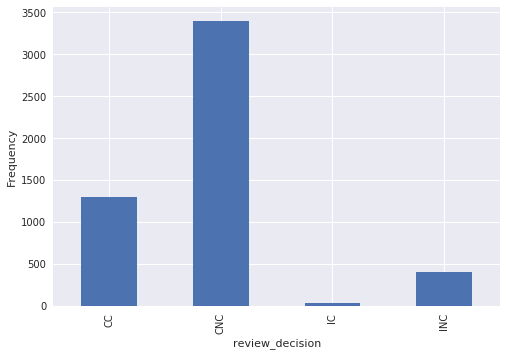

In [8]:
ax = (raw_df.groupby('review_decision')
            .size()
            .plot(kind='bar'))

ax.set_ylabel("Frequency");

The possible values of `review_decision` are
    
* `CC` for correct call,
* `CNC` for correct non-call,
* `IC` for incorrect call, and
* `INC` for incorrect non-call.

While `review_decision` decision provides information about both whether or not a foul was called and whether or not a foul was actually committed, this analysis will focus only on whether or not a foul was called.  Including whether or not a foul was actually committed in this analysis introduces some subtleties that are best left to a future post.

In this dataset, the "committing" player is the one that a foul would be called against, if a foul was called on the play, and the other player is "disadvantaged."

We now encode the data.  Since the committing player on one play may be the disadvantaged player on another play, we [`melt`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.melt.html) the raw data frame to have one row per player-play combination so that we can encode the players in a way that is consistent across columns.

In [9]:
PLAYER_MAP = {
    "Jose Juan Barea": "JJ Barea",
    "Nene Hilario": "Nene",
    "Tim Hardaway": "Tim Hardaway Jr",
    "James Ennis": "James Ennis III",
    "Kelly Oubre": "Kelly Oubre Jr",
    "Taurean Waller-Prince": "Taurean Prince",
    "Glenn Robinson": "Glenn Robinson III",
    "Otto Porter": "Otto Porter Jr"
}

TEAM_MAP = {
    "NKY": "NYK",
    "COS": "BOS",
    "SAT": "SAS"
}

In [10]:
long_df = (pd.melt(
                (raw_df.reset_index(drop=True)
                       .rename_axis('play_id')
                       .reset_index()),
                id_vars=['play_id', 'review_decision',
                         'committing_team', 'disadvantaged_team',
                         'seconds_left'],
                value_vars=['committing_player', 'disadvantaged_player'],
                var_name='player', value_name='player_name_')
             # fix inconsistent player names
             .assign(player_name=lambda df: (df.player_name_
                                               .str.replace('\.', '')
                                               .apply(lambda name: PLAYER_MAP.get(name, name))))
             .assign(team_=lambda df: (df.committing_team
                                         .where(df.player == 'committing_player',
                                                df.disadvantaged_team)))
             # fix typos in team names
             .assign(team=lambda df: df.team_.apply(lambda team: TEAM_MAP.get(team, team)))
             .drop(['committing_team', 'disadvantaged_team', 'team_'], axis=1))

long_df['player_id'], player_map = long_df.player_name.factorize()

In [11]:
long_df.head()

play_id review_decision  seconds_left             player     player_name_  \
0        0             CNC         102.0  committing_player  Al-Farouq Aminu   
1        1              CC          98.0  committing_player       Boris Diaw   
2        2             CNC          64.0  committing_player         Ed Davis   
3        3             INC          62.0  committing_player      Rudy Gobert   
4        4              CC          27.1  committing_player      CJ McCollum   

       player_name team  player_id  
0  Al-Farouq Aminu  POR          0  
1       Boris Diaw  UTA          1  
2         Ed Davis  POR          2  
3      Rudy Gobert  UTA          3  
4      CJ McCollum  POR          4

After encoding, we [pivot](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) back to a wide data frame with one row per play.

In [12]:
df = (long_df.pivot_table(index=['play_id', 'review_decision', 'seconds_left'],
                          columns='player', values='player_id')
             .rename(columns={
                 'committing_player': 'committing_id',
                 'disadvantaged_player': 'disadvantaged_id'
             })
             .rename_axis('', axis=1)
             .reset_index()
             .assign(foul_called=lambda df: 1 * (df.review_decision.isin(['CC', 'IC'])))
             .drop(['play_id', 'review_decision'],
                   axis=1))

In addition to encoding the players, we have include a column (`foul_called`) that indicates whether or not a foul was called on the play.

In [13]:
df.head()

seconds_left  committing_id  disadvantaged_id  foul_called
0         102.0              0               300            0
1          98.0              1               124            1
2          64.0              2               300            0
3          62.0              3                 4            0
4          27.1              4                 6            1

In order to understand how foul calls vary systematically across players, we will use salary as a proxy for "star power."  The salary data we use was downloaded from [Basketball Reference](http://www.basketball-reference.com/contracts/players.html).

In [14]:
SALARY_URI = 'http://www.austinrochford.com/resources/nba_irt/2016_2017_salaries.csv'

salary_df = (pd.read_csv(SALARY_URI, skiprows=1,
                         usecols=['Player', '2016-17'])
               .assign(player_name=lambda df: (df.Player
                                                 .str.split('\\', expand=True)[0]
                                                 .str.replace('\.', '')
                                                 # fix inconsistent player names
                                                 .apply(lambda name: PLAYER_MAP.get(name, name))),
                       salary=lambda df: (df['2016-17'].str
                                                       .lstrip('$')
                                                       .astype(np.float64)))
               .assign(log_salary=lambda df: np.log10(df.salary))
               .assign(std_log_salary=lambda df: (df.log_salary - df.log_salary.mean()) / df.log_salary.std())
               .drop(['Player', '2016-17'], axis=1)
               .groupby('player_name')
               .max()
               .select(lambda name: name in player_map)
               .assign(player_id=lambda df: (np.equal
                                               .outer(player_map, df.index)
                                               .argmax(axis=0)))
               .reset_index()
               .set_index('player_id')
               .sort_index())

Since NBA salaries span many orders of magnitude (LeBron James' salary is just shy of \$31M while the lowest paid player made just more than \$200K) we will use log salaries, standardized to have mean zero and standard deviation one in our model.

In [15]:
salary_df.head()

player_name     salary  log_salary  std_log_salary
player_id                                                        
0          Al-Farouq Aminu  7680965.0    6.885416        0.848869
1               Boris Diaw  7000000.0    6.845098        0.797879
2                 Ed Davis  6666667.0    6.823909        0.771080
3              Rudy Gobert  2121288.0    6.326600        0.142129
4              CJ McCollum  3219579.0    6.507799        0.371293

We also produce a dataframe associating players to teams, along with some useful per-player summaries.

In [16]:
team_player_map = (long_df.groupby('team')
                          .player_id
                          .apply(pd.Series.drop_duplicates)
                          .reset_index(level=-1, drop=True)
                          .reset_index()
                          .assign(name=lambda df: player_map[df.player_id],
                                  disadvantaged_rate=lambda tpm_df: (df.groupby('disadvantaged_id')
                                                                       .foul_called
                                                                       .mean()
                                                                       .ix[tpm_df.player_id]
                                                                       .values),
                                  disadvantaged_plays=lambda tpm_df: (df.groupby('disadvantaged_id')
                                                                        .size()
                                                                        .ix[tpm_df.player_id]
                                                                        .values))
                          .fillna(0))

In [17]:
team_player_map.head()

team  player_id  disadvantaged_plays  disadvantaged_rate             name
0  ATL        114                  8.0            0.000000      Kyle Korver
1  ATL        115                 13.0            0.538462    Dwight Howard
2  ATL        116                 44.0            0.272727     Paul Millsap
3  ATL        117                 60.0            0.283333  Dennis Schroder
4  ATL        181                 25.0            0.200000    Kent Bazemore

## Modeling

Throughout this post, we will develop a series of models for understanding how foul calls vary across players, starting with a simple beta-Bernoulli model and working our way up to a hierachical [item-response theory](https://en.wikipedia.org/wiki/Item_response_theory) regression model.

Before building models, we must introduce a bit of notation.  The index $i$ will correspond to a disadvantaged player and the index $j$ corresponds to a committing player.  The index $k$ corresponds to a play.  With this notation $i(k)$ and $j(k)$ are the index of the disadvantaged and committing player involved in play $k$, respectively.  The binary variable $y_k$ indicates whether or not a foul was called on play $k$.  All of our models use the likelihood

$$y_k \sim \textrm{Bernoulli}(p_{i(k), j(k)}).$$

Each model differs in its specification of the probability that a foul is called, $p_{i, j}$.

### Beta-Bernoulli model

One of the simplest possible models for this data focuses only on the disadvantaged player, so $p_{i, j} = p_i$, and places independent beta priors on each $p_i$. For simplicity, we begin with uniform priors, $p_i \sim \textrm{Beta}(1, 1).$

Even though this model is conjugate, we will use [`pymc3`](http://pymc-devs.github.io/pymc3/) to perform inference with it for consistency with subsequent, non-conjugate models.

In [18]:
n_players = player_map.size
disadvantaged_id = df.disadvantaged_id.values

foul_called = df.foul_called.values
obs_rate = foul_called.mean()

In [19]:
with pm.Model() as bb_model:
    p = pm.Beta('p', 1., 1., shape=n_players)
    
    y = pm.Bernoulli('y_obs', p[disadvantaged_id],
                     observed=foul_called)

Throughout this post, we will use the [no-U-turn sampler](https://arxiv.org/abs/1111.4246) for inference, tuning the sampler's hyperparameters for the first two thousand samples and subsequently keeping the next two thousand samples for inference.

In [20]:
N_TUNE = 2000
N_SAMPLES = 2000

SEED = 506421 # from random.org, for reproducibility

We now sample from the beta-Bernoulli model.

In [21]:
def sample(model, n_tune, n_samples, seed):
    with model:
        full_trace = pm.sample(n_tune + n_samples, tune=n_tune, random_seed=seed)
        
    return full_trace[n_tune:]

In [22]:
bb_trace = sample(bb_model, N_TUNE, N_SAMPLES, SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
  2%|▏         | 4793/200000 [00:02<01:47, 1818.84it/s]Median ELBO converged.
Finished [100%]: Average ELBO = -3,554.3

100%|██████████| 4000/4000 [01:03<00:00, 63.38it/s]


We use energy energy plots to diagnose possible problems with our samples.

In [23]:
def energy_plot(trace):
    energy = trace['energy']
    energy_diff = np.diff(energy)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    ax.hist(energy - energy.mean(), bins=30,
            lw=0, alpha=0.5,
            label="Energy")
    ax.hist(energy_diff, bins=30,
            lw=0, alpha=0.5,
            label="Energy difference")
    
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.legend()

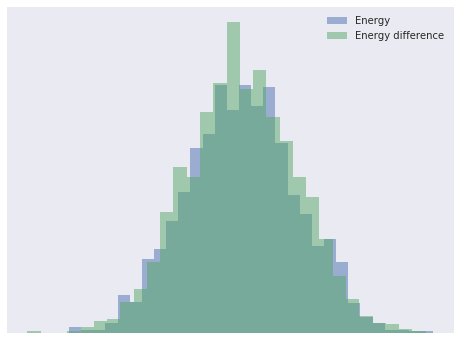

In [24]:
energy_plot(bb_trace)

Since the energy and energy difference distributions are quite similar, there is no indication from this plot of sampling issues.  For an in-depth treatment of Hamiltonian Monte Carlo algorithms and convergence diagnostics, consult [Michael Betancourt](https://betanalpha.github.io/)'s excellent paper [_A Conceptual Introduction to Hamiltonian Monte Carlo_](https://arxiv.org/abs/1701.02434).

We will use the [widely applicable information criterion](http://www.stat.columbia.edu/~gelman/research/unpublished/loo_stan.pdf) (WAIC) and binned residuals to check and compare our models.  WAIC is a Bayesian measure of out-of-sample predictive accuracy based on in-sample data that is quite closely related to [leave-one-out cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics%29#Leave-one-out_cross-validation).  It attempts to improve upon known shortcomings of the widely-used [deviance information criterion](https://en.wikipedia.org/wiki/Deviance_information_criterion).  (See [_Understanding predictive information criteria for Bayesian models_](http://www.stat.columbia.edu/~gelman/research/published/waic_understand3.pdf) for a review and comparison of various information criteria, including DIC and WAIC.)  WAIC is easy to calculate with `pymc3`.

In [25]:
def get_waic_df(model, trace, name):
    with model:
        waic = pm.waic(trace)

    return pd.DataFrame.from_records([waic], index=[name], columns=waic._fields)

In [26]:
waic_df = get_waic_df(bb_model, bb_trace, "Beta-Bernoulli")

/opt/conda/lib/python3.5/site-packages/pymc3/stats.py:145: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


We see that the WAIC calculation indicates difficulties with the beta-Bernoulii model, which we will soon confirm.

In [27]:
waic_df

WAIC   WAIC_se      p_WAIC
Beta-Bernoulli  6021.491064  66.23822  238.488377

In addition to the WAIC value, we get an estimate of its standard error (`WAIC_se`) and the number of effective parameters in the model (`p_WAIC`).  The number of effective parameters is an indication of model complexity.

The second diagnostic tool we use on our models are binned residuals, which show how well-calibrated the model's predicted probabilities are.  Intuitively, if our model predicts that an event has a 35% chance of occurring and we can observe many repetitions of that event, we would expect the event to actually occur about 35% of the time.  If the observed occurrences of the event differ substantially from the predicted rate, we have reason to doubt the quality of our model.  Since we generally can't observe each event many times, we instead group events into bins by their predicted probability and check that the average predicted probability in each bin is close to the rate at which the events in that bin are observed.

The binned predictions and residuals for the beta-Bernoulli model are shown below.

In [28]:
BINS = np.linspace(0, 1, 11)
BINS_3D = BINS[np.newaxis, np.newaxis]

def binned_residuals(y, p):
    p_3d = p[..., np.newaxis]

    in_bin = (BINS_3D[..., :-1] < p_3d) & (p_3d <= BINS_3D[..., 1:])
    bin_counts = in_bin.sum(axis=(0, 1))
    
    p_mean = (in_bin * p_3d).sum(axis=(0, 1)) / bin_counts
    y_mean = (in_bin * y[np.newaxis, :, np.newaxis]).sum(axis=(0, 1)) / bin_counts
    
    return y_mean, p_mean, bin_counts

def binned_residual_plot(bin_obs, bin_p, bin_counts):
    fig, (ax, resid_ax) = plt.subplots(ncols=2, sharex=True, figsize=(16, 6))

    ax.scatter(bin_p, bin_obs,
               s=300 * np.sqrt(bin_counts / bin_counts.sum()),
               zorder=5)
    ax.plot([0, 1], [0, 1], '--', c='k')

    ax.set_xlim(0, 1)
    ax.set_xticks(np.linspace(0, 1, 5))
    ax.xaxis.set_major_formatter(pct_formatter)
    ax.set_xlabel("Mean $p$ (binned)")

    ax.set_ylim(0, 1)
    ax.set_yticks(np.linspace(0, 1, 5))
    ax.yaxis.set_major_formatter(pct_formatter)
    ax.set_ylabel("Observed rate (binned)")

    resid_ax.scatter(bin_p, bin_obs - bin_p,
                     s=300 * np.sqrt(bin_counts / bin_counts.sum()),
                     zorder=5)

    resid_ax.hlines(0, 0, 1, 'k', '--')

    resid_ax.set_xlim(0, 1)
    resid_ax.set_xticks(np.linspace(0, 1, 5))
    resid_ax.xaxis.set_major_formatter(pct_formatter)
    resid_ax.set_xlabel("Mean $p$ (binned)")

    resid_ax.yaxis.set_major_formatter(pct_formatter)
    resid_ax.set_ylabel("Residual (binned)")

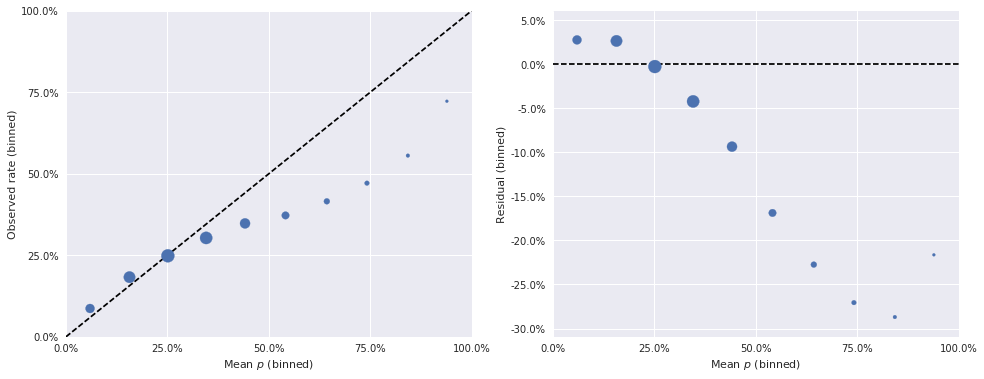

In [29]:
bin_obs, bin_p, bin_counts = binned_residuals(foul_called, bb_trace['p'][:, disadvantaged_id])

binned_residual_plot(bin_obs, bin_p, bin_counts)

In these plots, the dashed black lines show how these quantities would be related, for a perfect model.  The area of each point is proportional to the number of events whose predicted probability fell in the relevant bin.  From these plots, we get further confirmation that our simple beta-Bernoulli model is quite unsatisfactory, as many binned residuals exceed 5% in absolute value.

Below we plot the posterior mean and 90% credible interval for $p$ for each player in the data set (grouped by team, for legibility), along with the player's observed foul called percentage when disadvantaged.  The area of the point for observed foul called percentage is proportional to the number of plays in which the player was disadvantaged.

In [30]:
def to_param_df(player_df, trace, varnames):
    df = player_df
    
    for name in varnames:
        mean = trace[name].mean(axis=0)
        low, high = np.percentile(trace[name], [5, 95], axis=0)
        
        df = df.assign(**{
            '{}_mean'.format(name): mean[df.player_id],
            '{}_low'.format(name): low[df.player_id],
            '{}_high'.format(name): high[df.player_id]
        })
        
    return df

In [31]:
bb_df = to_param_df(team_player_map, bb_trace, ['p'])

In [32]:
def plot_params(mean, interval, names, ax=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    n_players = names.size

    ax.errorbar(mean, np.arange(n_players),
                xerr=np.abs(mean - interval),
                fmt='o',
                label="Mean with\n90% interval")
    

    ax.set_ylim(-1, n_players)
    ax.set_yticks(np.arange(n_players))
    ax.set_yticklabels(names)
    
    return ax

def plot_p_params(rate, n_plays, league_mean, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
        
    n_players = rate.size
        
    ax.scatter(rate, np.arange(n_players),
               c='k', s=20 * np.sqrt(n_plays),
               alpha=0.5, zorder=5,
               label="Observed")

    ax.vlines(league_mean, -1, n_players,
              'k', '--',
              label="League average")
    
def plot_p_helper(mean, low, high, rate, n_plays, names, league_mean=None, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    
    mean = mean.values
    rate = rate.values
    n_plays = n_plays.values
    names = names.values
    
    argsorted_ix = mean.argsort()
    interval = np.row_stack([low, high])
    
    plot_params(mean[argsorted_ix], interval[:, argsorted_ix], names[argsorted_ix],
                ax=ax, **kwargs)
    plot_p_params(rate[argsorted_ix], n_plays[argsorted_ix], league_mean,
                  ax=ax, **kwargs)

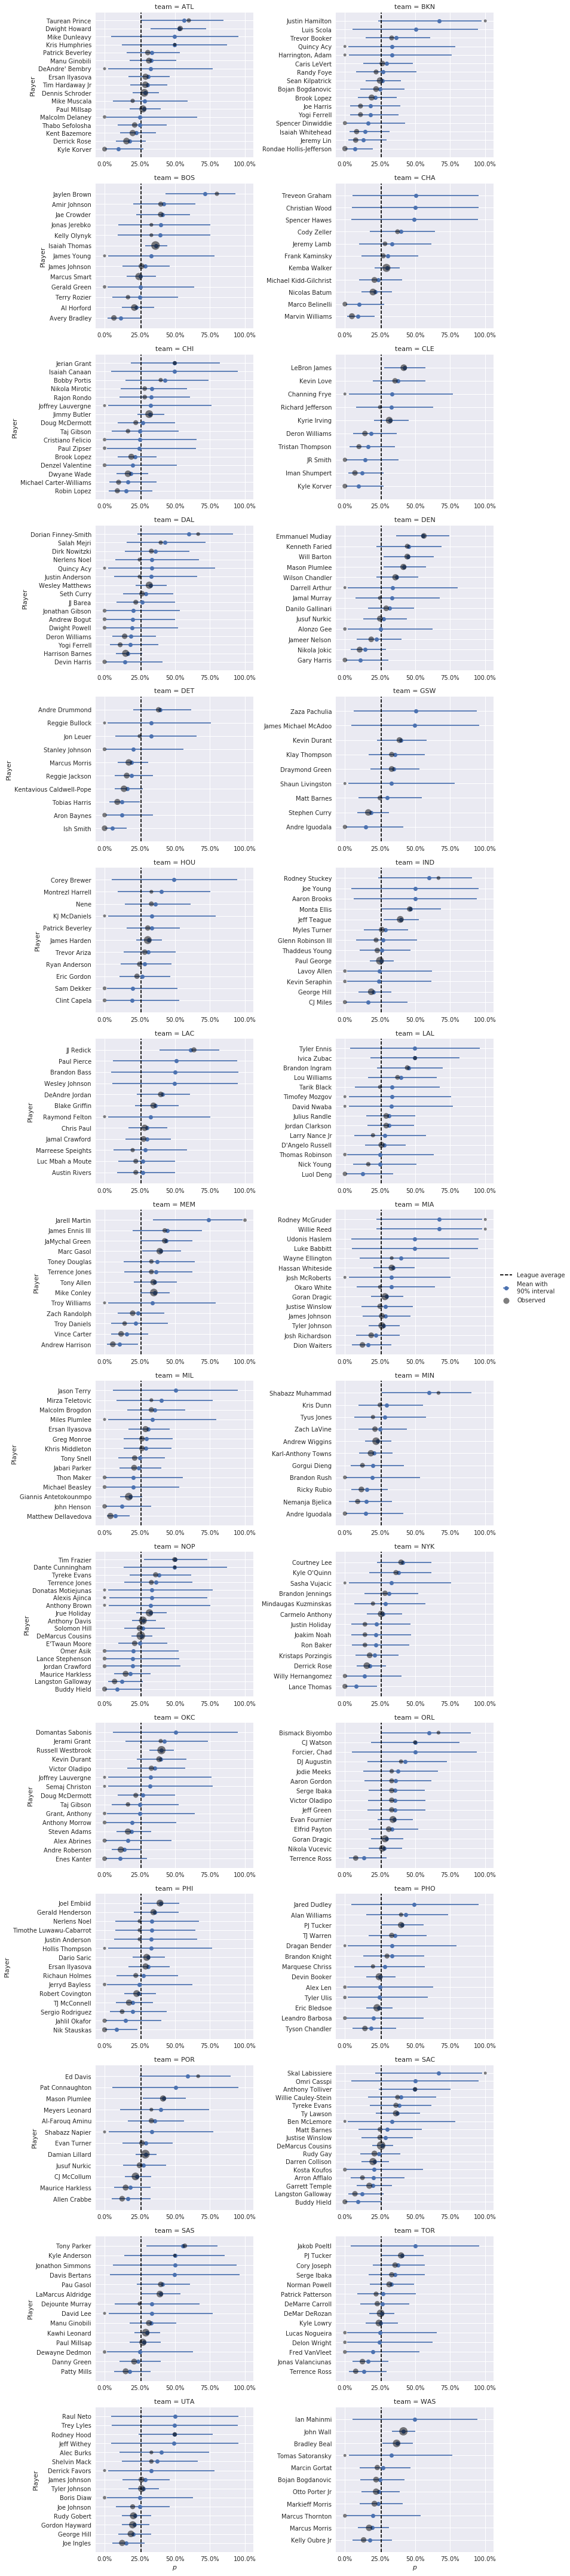

In [33]:
grid = sns.FacetGrid(bb_df, col='team', col_wrap=2,
                     sharey=False,
                     size=4, aspect=1.5)
grid.map(plot_p_helper,
         'p_mean', 'p_low', 'p_high',
         'disadvantaged_rate', 'disadvantaged_plays', 'name',
         league_mean=obs_rate);

grid.set_axis_labels(r"$p$", "Player");

for ax in grid.axes:
    ax.set_xticks(np.linspace(0, 1, 5));
    ax.set_xticklabels(ax.get_xticklabels(), visible=True)
    ax.xaxis.set_major_formatter(pct_formatter);
    
grid.fig.tight_layout();
grid.add_legend();

These plots reveal an undesirable property of this model and its inferences.  Since the prior distribution on $p_i$ is uniform on the interval $[0, 1]$, all posterior estimates of $p_i$ are pulled towards the prior expected value of 50%.  This phenomenon is known as shrinkage.  In extreme cases of players that were never disadvantaged, the posterior estimate of $p_i$ is quite close to 50%.  For these players, the league average foul call rate would seem to be a much more reasonable estimate of $p_i$ than 50%.  The league average foul call rate is shown as a dotted black line on the charts above.

There are several possible modifications of the beta-Bernoulli model that can cause shrinkage toward the league average.  Perhaps the most straightforward is the [empirical Bayesian method](https://en.wikipedia.org/wiki/Empirical_Bayes_method) that sets the parameters of the prior distribution on $p_i$ using the observed data.  In this framework, there are many methods of choosing prior hyperparameters that make the prior expected value equal to the league average, therefore causing shrinkage toward the league average.  We do not use empirical Bayesian methods in this post as they make it cumbersome to build the more complex models we want to use to understand the relationship between salary and foul calls.  Empirical Bayesian methods are, however, an approximation to the fully hierachical models we begin building in the next section.

### Hierarchical logistic-normal model

A hierarchical [logistic-normal](https://en.wikipedia.org/wiki/Logit-normal_distribution) model addresses some of the shortcomings of the beta-Bernoulli model.  For simplicity, this model focuses exclusively on the disadvantaged player and assumes that the [log-odds](https://en.wikipedia.org/wiki/Logit) of a foul call for a given disadvantaged player are normally distributed.  That is,

$$
\begin{align*}
\log \left(\frac{p_i}{1 - p_i}\right) &
    \sim N(\mu, \sigma^2) \\
\eta_{k}
    & = \log \left(\frac{p_{i(k)}}{1 - p_{i(k)}}\right),
\end{align*}$$

which is equivalent to 

$$p_{i(k)} = \frac{1}{1 + \exp(-\eta_k)}.$$

We address the beta-Bernoulli model's shrinkage problem by placing a normal hyperprior distribution on $\mu$, $\mu \sim N(0, 100).$  This shared hyperprior makes this model hierarchical.  To complete the specification of this model, we place a half-[Cauchy](https://en.wikipedia.org/wiki/Cauchy_distribution) prior on $\sigma$, $\sigma \sim \textrm{HalfCauchy}(2.5)$.

In [34]:
with pm.Model() as ln_model:
    μ = pm.Normal('μ', 0., 10.)
    Δ = pm.Normal('Δ', 0., 1., shape=n_players)
    σ = pm.HalfCauchy('σ', 2.5)
    
    p_player = pm.Deterministic('p_player', pm.math.sigmoid(μ + Δ * σ))

    η = μ + Δ[disadvantaged_id] * σ
    p = pm.Deterministic('p', pm.math.sigmoid(η))

    y = pm.Bernoulli('y_obs', p, observed=foul_called)

Throughout this post we use an [offset parameterization](http://twiecki.github.io/blog/2017/02/08/bayesian-hierchical-non-centered/) for hierarchical models that significantly improves sampling efficiency.  We now sample from this model.

In [35]:
ln_trace = sample(ln_model, N_TUNE, N_SAMPLES, SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
  9%|▊         | 17001/200000 [00:12<02:13, 1372.87it/s]Median ELBO converged.
Finished [100%]: Average ELBO = -3,520.3

100%|██████████| 4000/4000 [02:27<00:00, 65.27it/s]


The energy plot for this model gives no cause for concern.

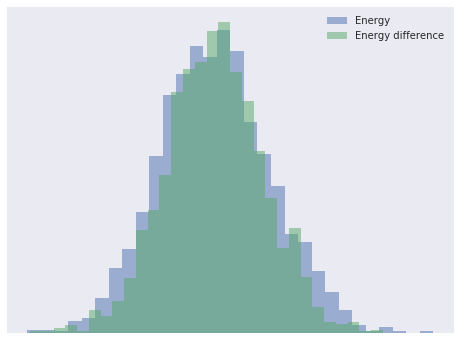

In [36]:
energy_plot(ln_trace)

We now calculate the WAIC of the logistic-normal model, and compare it to that of the beta-Bernoulli model.

In [37]:
waic_df = waic_df.append(get_waic_df(ln_model, ln_trace, "Logistic-normal"))

In [38]:
def waic_plot(waic_df):
    fig, (waic_ax, p_ax) = plt.subplots(ncols=2, sharex=True, figsize=(16, 6))

    waic_x = np.arange(waic_df.shape[0])

    waic_ax.errorbar(waic_x, waic_df.WAIC,
                     yerr=waic_df.WAIC_se,
                     fmt='o')

    waic_ax.set_xticks(waic_x)
    waic_ax.xaxis.grid(False)
    waic_ax.set_xticklabels(waic_df.index)
    waic_ax.set_xlabel("Model")

    waic_ax.set_ylabel("WAIC")

    p_ax.bar(waic_x, waic_df.p_WAIC)

    p_ax.xaxis.grid(False)
    p_ax.set_xlabel("Model")

    p_ax.set_ylabel("Effective number\nof parameters")

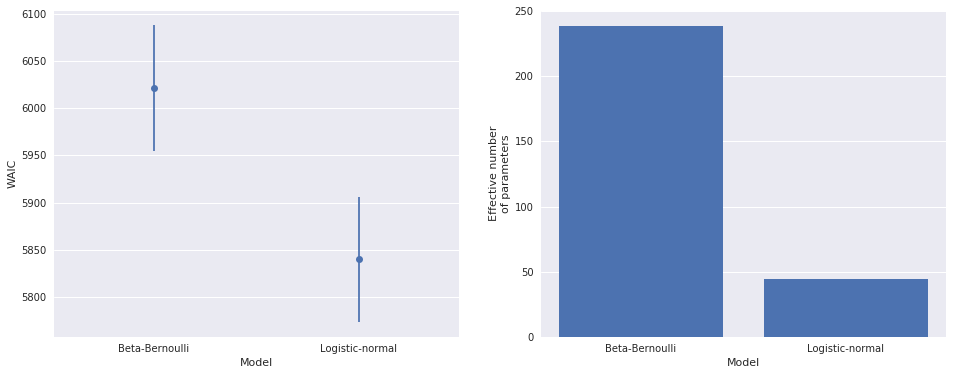

In [39]:
waic_plot(waic_df)

The left-hand plot above shows that the logistic-normal model is a significant improvement in WAIC over the beta-Bernoulli model, which is unsurprising.  The right-hand plot shows that the logistic-normal model has roughly 20% the number of effective parameters as the beta-Bernoulli model.  This reduction is due to the partial pooling effect of the hierarchical prior.  The hyperprior on $\mu$ causes observations for one player to impact the estimate of $p_i$ for all players; this sharing of information across players is responsible for the large decrease in the number of effective parameters.

Finally, we examine the binned residuals for the logistic-normal model.

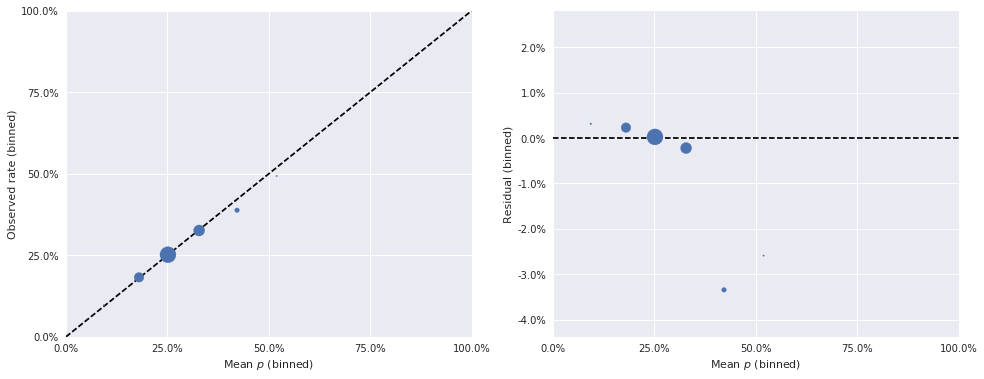

In [40]:
bin_obs, bin_p, bin_counts = binned_residuals(foul_called, ln_trace['p'])

binned_residual_plot(bin_obs, bin_p, bin_counts)

These binned residuals are much smaller than those of the beta-Bernoulli model, which is further confirmation that the logistic-normal model is preferable.

Below we plot the posterior distribution of $\operatorname{logit}^{-1}(\mu)$, and we see that the observed foul call rate of approximately 25.1% lies within its 90% interval.

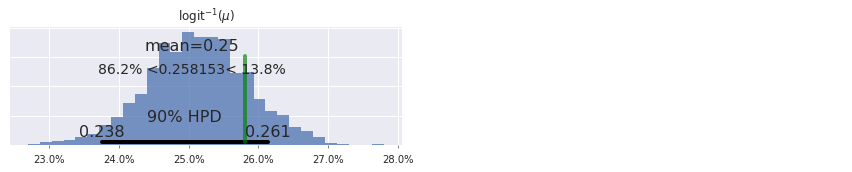

In [41]:
ax, = pm.plot_posterior(ln_trace, ['μ'],
                        alpha_level=0.1, transform=expit, ref_val=obs_rate,
                        lw=0., alpha=0.75)

ax.xaxis.set_major_formatter(pct_formatter);

ax.set_title(r"$\operatorname{logit}^{-1}(\mu)$");

With this posterior for $\operatorname{logit}^{-1}(\mu)$, we see the desired posterior shrinkage of each $p_i$ toward the observed foul call rate.

In [42]:
ln_df = to_param_df(team_player_map, ln_trace, ['p'])

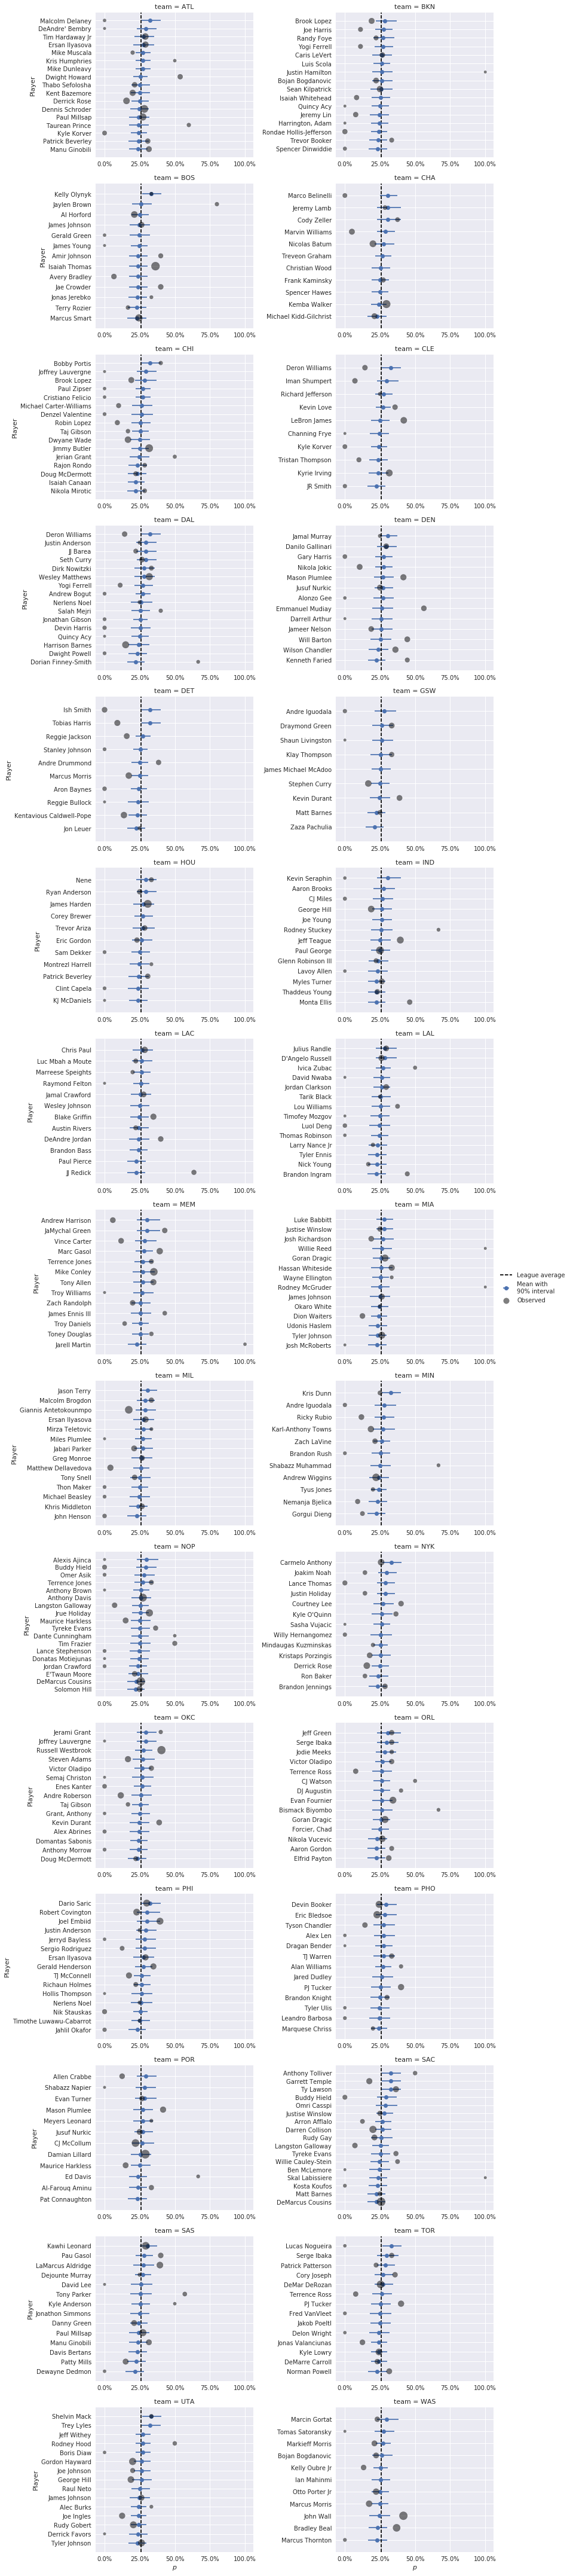

In [43]:
grid = sns.FacetGrid(ln_df, col='team', col_wrap=2,
                     sharey=False,
                     size=4, aspect=1.5)
grid.map(plot_p_helper,
         'p_mean', 'p_low', 'p_high',
         'disadvantaged_rate', 'disadvantaged_plays', 'name',
         league_mean=obs_rate);

grid.set_axis_labels(r"$p$", "Player");

for ax in grid.axes:
    ax.set_xticks(np.linspace(0, 1, 5));
    ax.set_xticklabels(ax.get_xticklabels(), visible=True)
    ax.xaxis.set_major_formatter(pct_formatter);
    
grid.fig.tight_layout();
grid.add_legend();

The inferences in these plots are markedly different from those of the beta-Bernoulli model.  Most strikingly, we see that estimates have been shrunk towards the league average foul call rate, and that players that were never disadvantaged have posterior foul call probabilities quite close to that rate.  As a consequence of this more reasonable shrinkage, the range of values taken by the posterior $p_i$ estimates is much smaller for the logistic-normal model than for the beta-Bernoulli model.  Below we plot the top- and bottom-ten players by $p_i$.

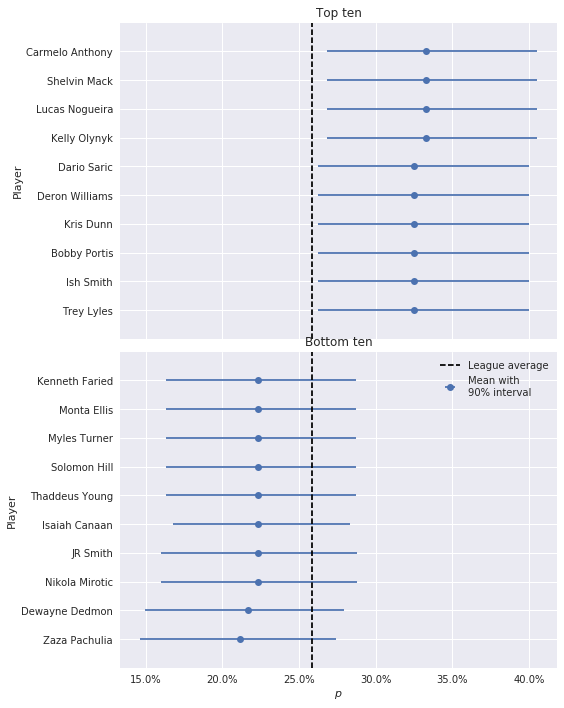

In [44]:
fig, (top_ax, bottom_ax) = plt.subplots(nrows=2, sharex=True, figsize=(8, 10))

by_p = (ln_df.drop_duplicates(['player_id'])
             .sort_values('p_mean'))
p_top = by_p.iloc[-10:]

plot_params(p_top.p_mean.values, p_top[['p_low', 'p_high']].values.T,
            p_top.name.values,
            ax=top_ax);
top_ax.vlines(obs_rate, -1, 10,
              'k', '--',
              label=r"League average");

top_ax.xaxis.set_major_formatter(pct_formatter);

top_ax.set_ylabel("Player");

top_ax.set_title("Top ten");

p_bottom = by_p.iloc[:10]

plot_params(p_bottom.p_mean.values, p_bottom[['p_low', 'p_high']].values.T,
            p_bottom.name.values,
            ax=bottom_ax);
bottom_ax.vlines(obs_rate, -1, 10,
                 'k', '--',
                 label=r"League average");

bottom_ax.xaxis.set_major_formatter(pct_formatter);
bottom_ax.set_xlabel(r"$p$");

bottom_ax.set_ylabel("Player");

fig.tight_layout();
bottom_ax.legend(loc=1);
bottom_ax.set_title("Bottom ten");

### Item-response (Rasch) model

The hierarchical logistic-normal model is certainly an improvement over the beta-Bernoulli model, but both of these models have focused solely on the disadvantaged player.  It seems quite important to understand the contribution of not just the disadvantaged player, but also of the committing player in each play to the probability of a foul call.  [Item-response theory](https://en.wikipedia.org/wiki/Item_response_theory) (IRT) provides generalizations the logistic-normal model that can account for the influence of both players involved in a play.  IRT originated in psychometrics as a way to simultaneously measure individual aptitude and question difficulty based on test-response data, and has subsequently found many other applications.  We use IRT to model foul calls by considering disadvantaged players as analagous to test takers and committing players as analagous to questions.  Specifically, we will use the [Rasch model](https://en.wikipedia.org/wiki/Rasch_model) for the probability $p_{i, j}$, that a foul is called on a play where player $i$ is disadvantaged by committing player $j$.  This model posits that each player has a latent ability, $\theta_i$, that governs how often fouls are called when they are disadvantaged and a latent difficulty $b_j$ that governs how often fouls are not called when they are committing.  The probability that a foul is called on a play where player $i$ is disadvantaged and player $j$ is committing is then a function of the difference between the corresponding latent ability and difficulty parameters,

$$
\begin{align*}
\eta_k
    & = \theta_{i(k)} - b_{j(k)} \\
p_k
    & = \frac{1}{1 + \exp(-\eta_k)}.
\end{align*}
$$

In this model, a player with a large value of $\theta_i$ is more likely to get a foul called when they are disadvantaged, and a player with a large value of $b_j$ is less likely to have a foul called when they are committing.  If $\theta_{i(k)} = b_{j(k)}$, there is a 50% chance a foul is called on that play.

To complete the specification of this model, we place priors on $\theta_i$ and $b_j$.  Similarly to $\eta$ in the logistic-normal model, we place a hierarchical normal prior on $\theta_i$,

$$
\begin{align*}
\mu_{\theta}
    & \sim N(0, 100) \\
\sigma_{\theta}
    & \sim \textrm{HalfCauchy}(2.5) \\
\theta_i
    & \sim N(\mu_{\theta}, \sigma^2_{\theta}).
\end{align*}
$$

In [45]:
with pm.Model() as rasch_model:
    μ_θ = pm.Normal('μ_θ', 0., 10.)
    Δ_θ = pm.Normal('Δ_θ', 0., 1., shape=n_players)
    σ_θ = pm.HalfCauchy('σ_θ', 2.5)
    θ = pm.Deterministic('θ', μ_θ + Δ_θ * σ_θ)

We also place a hierarchical normal prior on $b_j$, though this prior must be subtley different from that on $\theta_i$.  Since $\theta_i$ and $b_j$ are latent variables, there is no natural scale on which they should be measured.  If each $\theta_i$ and $b_j$ are shifted by the same amount, say $\delta$, the likelihood does not change.  That is, if $\tilde{\theta}_i = \theta_i + \delta$ and $\tilde{b}_j = b_j + \delta$, then

$$
\tilde{\eta}_{i, j} = \tilde{\theta}_i - \tilde{b}_j
    = \theta_i + \delta - (b_j + \delta)
    = \theta_i - b_j
    = \eta_{i, j}.
$$

Therefore, if we allow $\theta_i$ and $\beta_j$ to be shifted by arbitrary amounts, the Rasch model is not [identified](https://en.wikipedia.org/wiki/Identifiability). We identify the Rasch model by constraining the mean of the hyperprior on $b_j$ to be zero,

$$
\begin{align*}
\sigma_b
    & \sim \textrm{HalfCauchy}(2.5) \\
b_j
    & \sim N(0, \sigma^2_b).
\end{align*}
$$

In [46]:
with rasch_model:
    Δ_b = pm.Normal('Δ_b', 0., 1., shape=n_players)
    σ_b = pm.HalfCauchy('σ_b', 2.5)
    b = pm.Deterministic('b', Δ_b * σ_b)

We now specify the Rasch model's likelihood and sample from it.

In [47]:
committing_id = df.committing_id.values

In [48]:
with rasch_model:
    η = θ[disadvantaged_id] - b[committing_id]
    p = pm.Deterministic('p', pm.math.sigmoid(η))

    y = pm.Bernoulli('y_obs', p, observed=foul_called)

In [49]:
rasch_trace = sample(rasch_model, N_TUNE, N_SAMPLES, SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -3,729.5:  11%|█▏        | 22583/200000 [00:19<02:33, 1156.17it/s]Median ELBO converged.
Finished [100%]: Average ELBO = -3,037.1

100%|██████████| 4000/4000 [02:01<00:00, 32.81it/s]


Again, the energy plot for this model gives no cause for concern.

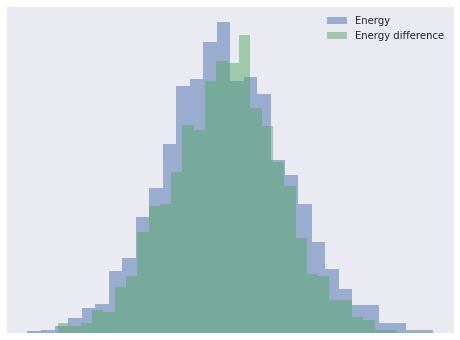

In [50]:
energy_plot(rasch_trace)

Below we show the WAIC of our three models.

In [51]:
waic_df = waic_df.append(get_waic_df(rasch_model, rasch_trace, "Rasch"))

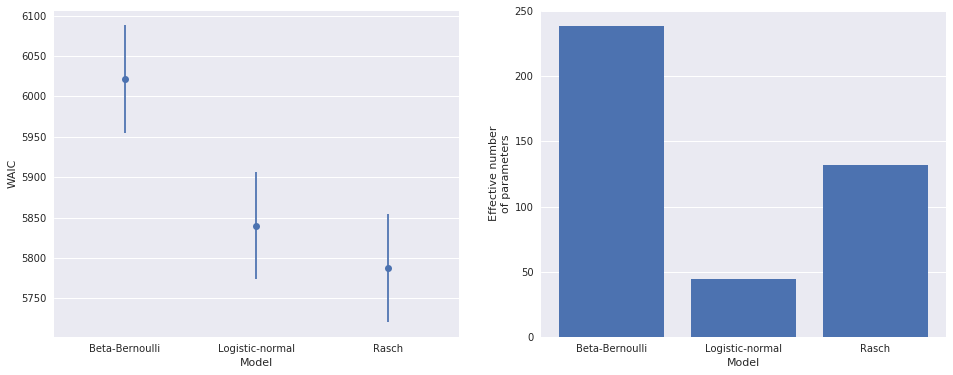

In [52]:
waic_plot(waic_df)

The Rasch model represents a moderate WAIC improvement over the logistic-normal model, and unsurprisingly has many more effective parameters (since it added a nominal parameter, $b_j$, per player).

The Rasch model also has reasonable binned residuals, with very few events having residuals above 5%.

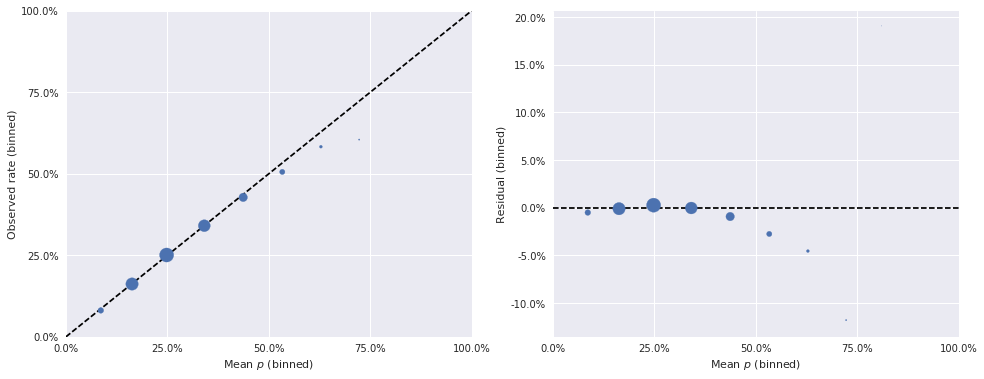

In [53]:
bin_obs, bin_p, bin_counts = binned_residuals(foul_called, rasch_trace['p'])

binned_residual_plot(bin_obs, bin_p, bin_counts)

For the Rasch model (and subsequent models), we switch from visualizing the per-player call probabilities to the latent parameters $\theta_i$ and $b_j$.

In [54]:
μ_θ_mean = rasch_trace['μ_θ'].mean()

rasch_df = to_param_df(team_player_map, rasch_trace, ['θ', 'b'])

In [55]:
def plot_params_helper(mean, low, high, names, league_mean=None, league_mean_name=None, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    
    mean = mean.values
    names = names.values
    
    argsorted_ix = mean.argsort()
    interval = np.row_stack([low, high])
    
    plot_params(mean[argsorted_ix], interval[:, argsorted_ix], names[argsorted_ix],
                ax=ax, **kwargs)
    
    if league_mean is not None:
        ax.vlines(league_mean, -1, names.size,
                  'k', '--',
                  label=league_mean_name)

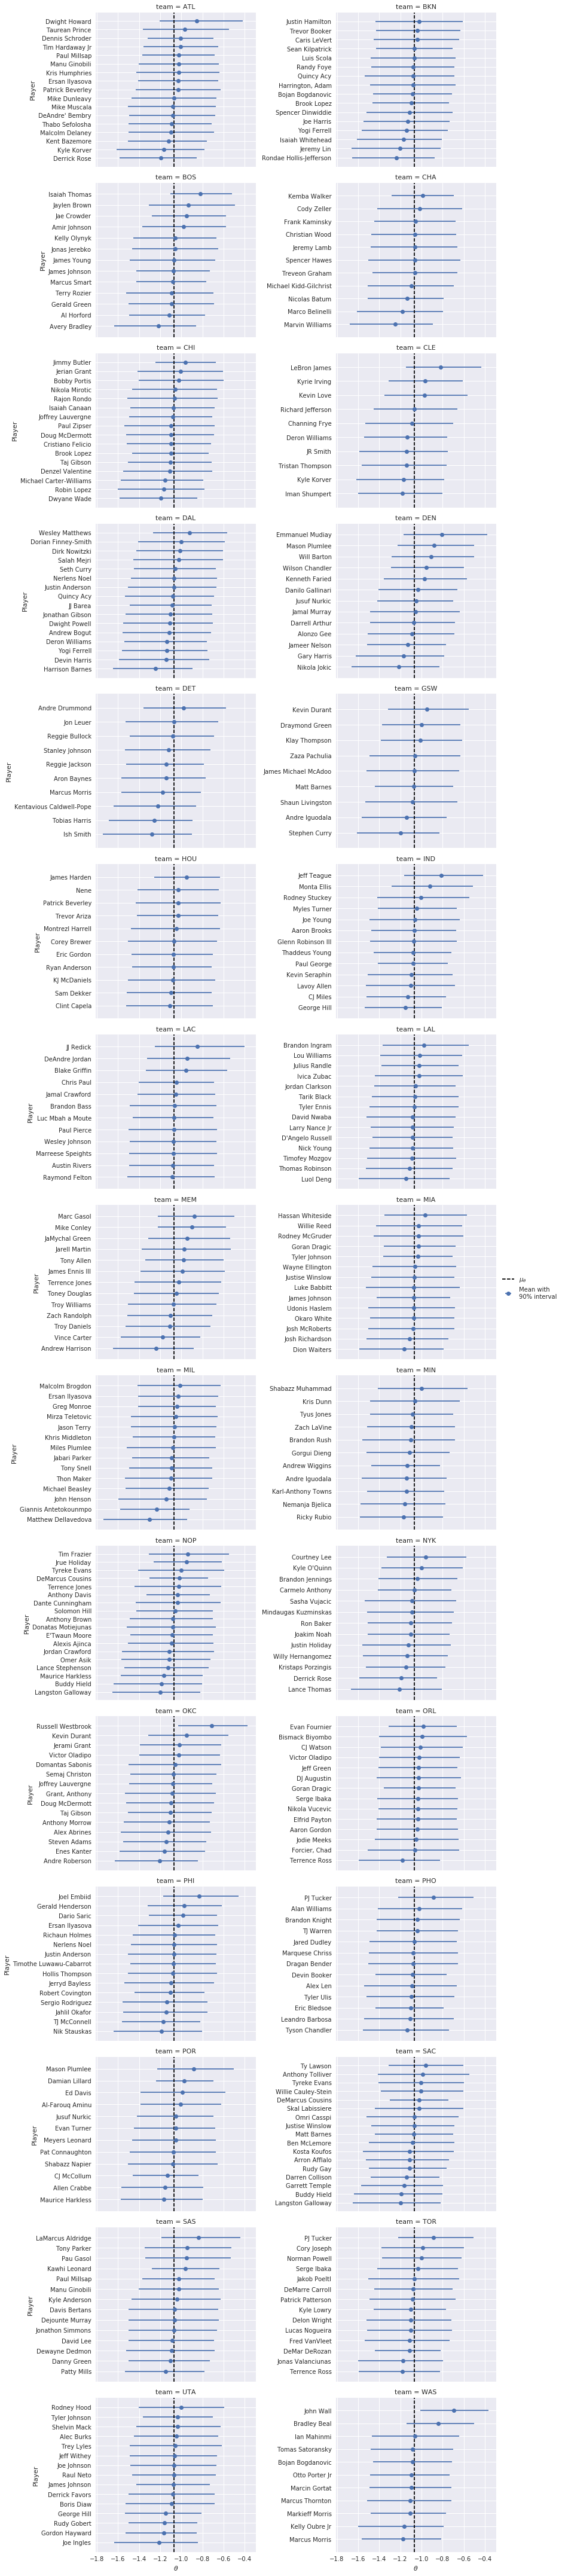

In [56]:
grid = sns.FacetGrid(rasch_df, col='team', col_wrap=2,
                     sharey=False,
                     size=4, aspect=1.5)
grid.map(plot_params_helper,
         'θ_mean', 'θ_low', 'θ_high', 'name',
         league_mean=μ_θ_mean,
         league_mean_name=r"$\mu_{\theta}$");

grid.set_axis_labels(r"$\theta$", "Player");

grid.fig.tight_layout();
grid.add_legend();

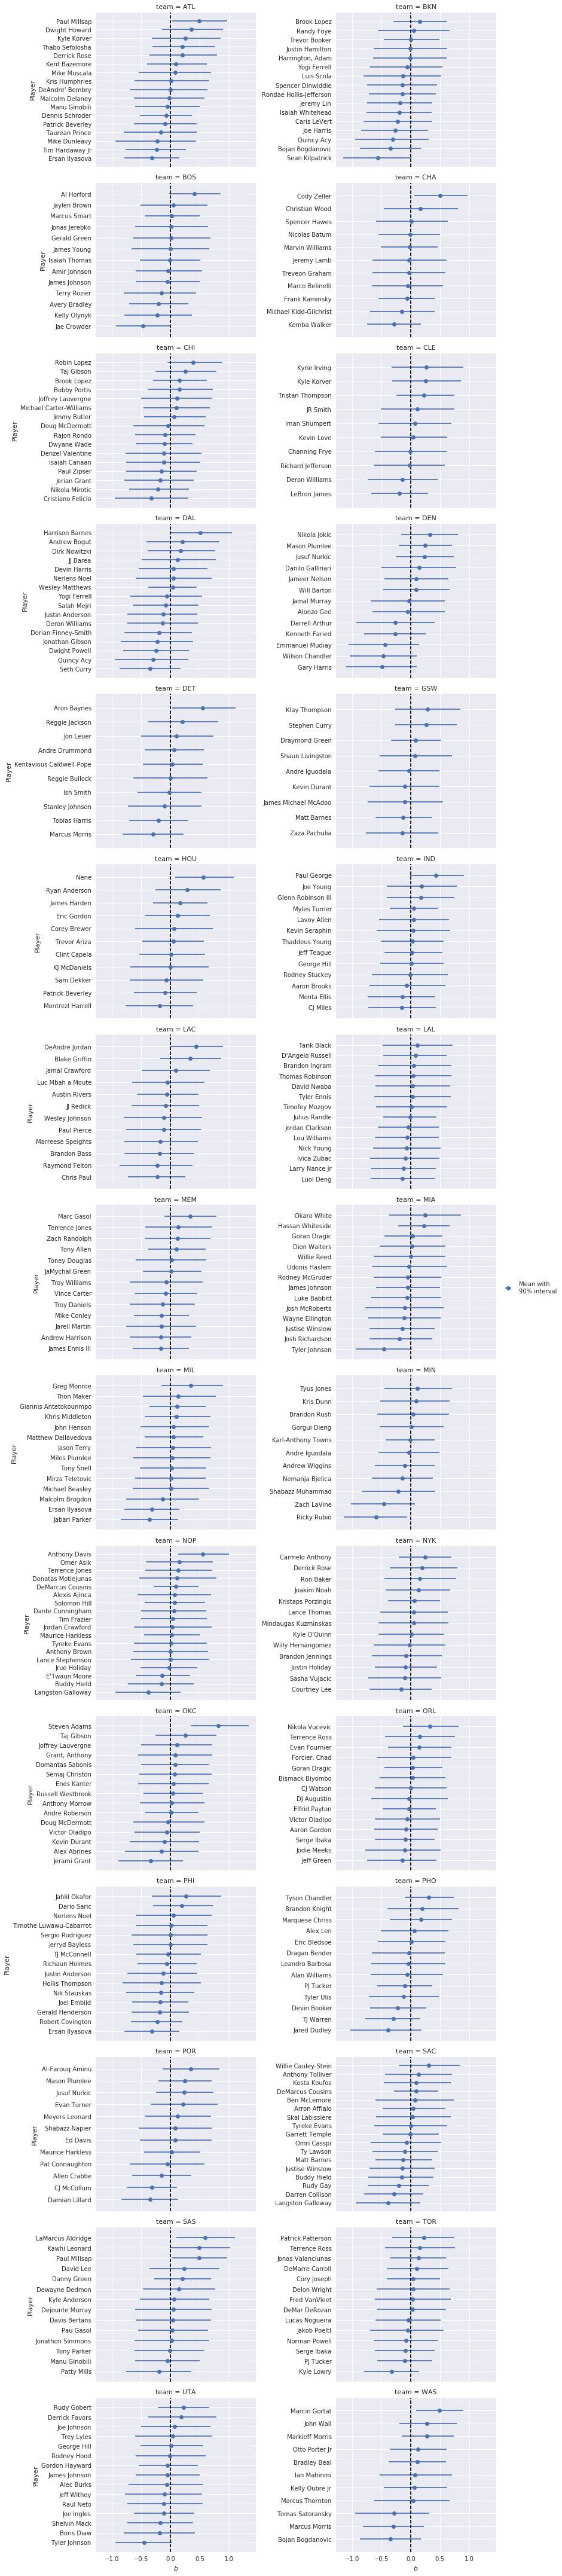

In [57]:
grid = sns.FacetGrid(rasch_df, col='team', col_wrap=2,
                     sharey=False,
                     size=4, aspect=1.5)
grid.map(plot_params_helper,
         'b_mean', 'b_low', 'b_high', 'name',
         league_mean=0.);

grid.set_axis_labels(r"$b$", "Player");

grid.fig.tight_layout();
grid.add_legend();

Though these plots are voluminuous and therefore difficult to interpret precisely, a few trends are evident.  The first is that there is more variation in the committing skill ($b_j$) than in disadvantaged skill ($\theta_i$).  This difference is confirmed in the following histograms of the posterior expected values of $\theta_i$ and $b_j$.

In [58]:
def plot_latent_distributions(θ, b):
    fig, (θ_ax, b_ax) = plt.subplots(nrows=2, sharex=True, figsize=(8, 6))
    
    bins = np.linspace(0.9 * min(θ.min(), b.min()),
                       1.1 * max(θ.max(), b.max()),
                       75)

    θ_ax.hist(θ, bins=bins,
              alpha=0.75)

    θ_ax.xaxis.set_label_position('top') 
    θ_ax.set_xlabel(r"Posterior expected $\theta$")

    θ_ax.set_yticks([])
    θ_ax.set_ylabel("Frequency")

    b_ax.hist(b, bins=bins,
              color=green, alpha=0.75)

    b_ax.xaxis.tick_top()
    b_ax.set_xlabel(r"Posterior expected $b$")

    b_ax.set_yticks([])
    b_ax.invert_yaxis()
    b_ax.set_ylabel("Frequency")

    fig.tight_layout()

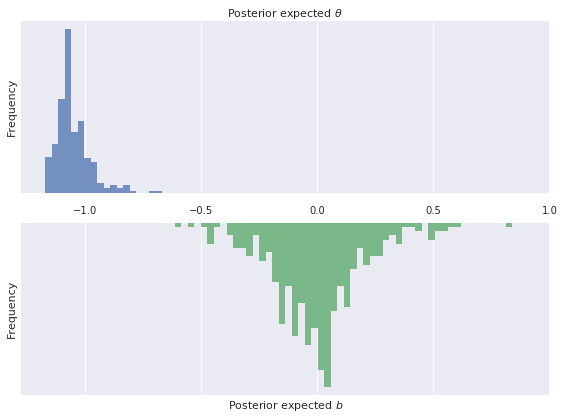

In [59]:
plot_latent_distributions(rasch_df.θ_mean, rasch_df.b_mean)

The following plots show the top and bottom ten players in terms of both $\theta_i$ and $b_j$.

In [60]:
def top_10_plot(trace_df, μ_θ=0):
    fig = plt.figure(figsize=(16, 10))
    θ_top_ax = fig.add_subplot(221)
    b_top_ax = fig.add_subplot(222)
    θ_bottom_ax = fig.add_subplot(223, sharex=θ_top_ax)
    b_bottom_ax = fig.add_subplot(224, sharex=b_top_ax)

    # necessary for players that have been on more than one team
    trace_df = trace_df.drop_duplicates(['player_id'])
    
    by_θ = trace_df.sort_values('θ_mean')
    θ_top = by_θ.iloc[-10:]
    θ_bottom = by_θ.iloc[:10]

    plot_params(θ_top.θ_mean.values, θ_top[['θ_low', 'θ_high']].values.T,
                θ_top.name.values,
                ax=θ_top_ax)
    θ_top_ax.vlines(μ_θ, -1, 10,
                    'k', '--',
                    label=(r"$\mu_{\theta}$" if μ_θ != 0 else "League average"))

    plt.setp(θ_top_ax.get_xticklabels(), visible=False)
    
    θ_top_ax.set_ylabel("Player")

    θ_top_ax.legend(loc=2)
    θ_top_ax.set_title("Top ten")

    plot_params(θ_bottom.θ_mean.values, θ_bottom[['θ_low', 'θ_high']].values.T,
                θ_bottom.name.values,
                ax=θ_bottom_ax)
    θ_bottom_ax.vlines(μ_θ, -1, 10,
                       'k', '--',
                       label=(r"$\mu_{\theta}$" if μ_θ != 0 else "League average"))

    θ_bottom_ax.set_xlabel(r"$\theta$")

    θ_bottom_ax.set_ylabel("Player")

    θ_bottom_ax.set_title("Bottom ten")

    by_b = trace_df.sort_values('b_mean')
    b_top = by_b.iloc[-10:]
    b_bottom = by_b.iloc[:10]

    plot_params(b_top.b_mean.values, b_top[['b_low', 'b_high']].values.T,
                b_top.name.values,
                ax=b_top_ax)
    b_top_ax.vlines(0, -1, 10,
                    'k', '--',
                    label="League average");

    plt.setp(b_top_ax.get_xticklabels(), visible=False)

    b_top_ax.legend(loc=2)
    b_top_ax.set_title("Top ten")

    b_bottom_player_id = b.argsort()[:10]

    plot_params(b_bottom.b_mean.values, b_bottom[['b_low', 'b_high']].values.T,
                b_bottom.name.values,
                ax=b_bottom_ax)
    b_bottom_ax.vlines(0, -1, 10,
                       'k', '--')

    b_bottom_ax.set_xlabel(r"$b$")

    b_bottom_ax.set_title("Bottom ten")

    fig.tight_layout()

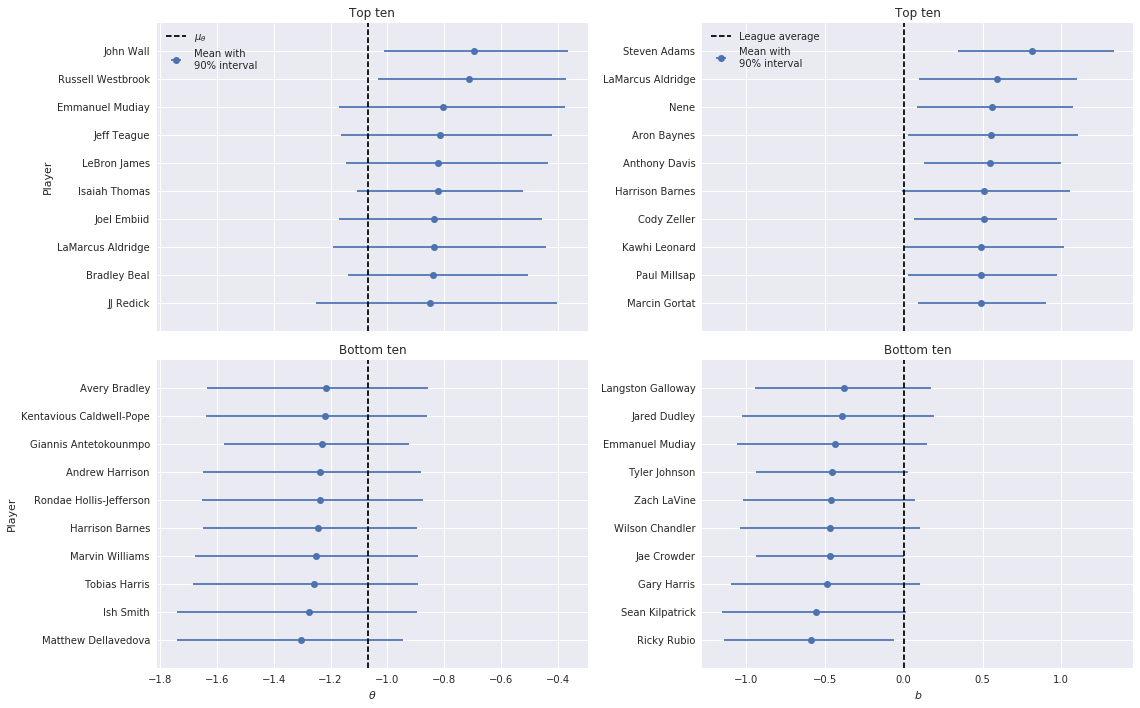

In [61]:
top_10_plot(rasch_df, μ_θ=μ_θ_mean)

We focus first on $\theta_i$.  Interestingly, the top-ten players for the Rasch model contains many more top-tier stars than the logistic-normal model, including John Wall, Russell Westbrook, and LeBron James.  Turning to $b$, it is interesting that the while the top and bottom ten players contain many recognizable names (LaMarcus Aldridge, Harrison Barnes, Kawhi Leonard, and Ricky Rubio) the only truly top-tier player present is Anthony Davis.

### Time remaining model

As basketball fans know, there are many factors other than the players involved that influence foul calls.  Very often, sufficiently close NBA games end with intentional fouls, as the losing team attempts to stop the clock and force another offensive possesion.  Therefore, we expect to see in increase in the foul call probability as the game nears its conclusion.

In [62]:
n_sec = 121
sec = (df.seconds_left
         .round(0)
         .values
         .astype(np.int64))

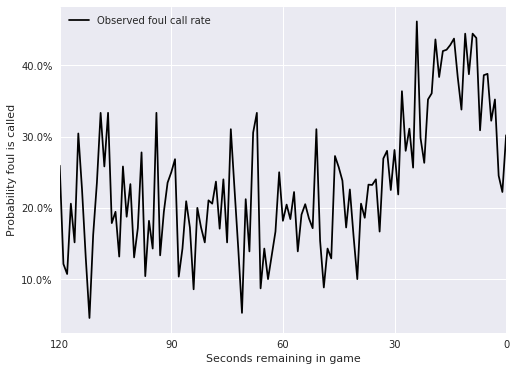

In [63]:
fig, ax = plt.subplots(figsize=(8, 6))

(df.groupby(sec)
   .foul_called
   .mean()
   .plot(c='k', label="Observed foul call rate", ax=ax));

ax.set_xticks(np.linspace(0, 120, 5));
ax.invert_xaxis();
ax.set_xlabel("Seconds remaining in game");

ax.yaxis.set_major_formatter(pct_formatter);
ax.set_ylabel("Probability foul is called");

ax.legend(loc=2);

The plot above confirms this expectation, which we can use to improve our latent skill model.  If $t \in \{0, 1, \ldots, 120\}$ is the number of seconds remaining in the game, we model the latent contribution of $t$ to the logodds that a foul is called with a [Gaussian random walk](https://en.wikipedia.org/wiki/Random_walk#Gaussian_random_walk),

$$
\begin{align*}
\lambda_0
    & \sim N(0, 100) \\
\lambda_t
    & \sim N(\lambda_{t - 1}, \tau^{-1}_{\lambda}) \\
\tau_{\lambda}
    & \sim \textrm{Exp}(10^{-4}).
\end{align*}
$$

This prior allows us to flexibly model the shape of the curve shown above.  If $t(k)$ is the number of seconds remaining during the $k$-th play, we incorporate $\lambda_{t(k)}$ into our model with

$$\eta_k = \lambda_{t(k)} + \theta_{i(k)} - b_{j(k)}.$$

This model is not identified until we constrain the mean of $\theta$ to be zero, for reasons similar to those discussed above for the Rasch model.

In [64]:
with pm.Model() as time_model:
    τ_λ = pm.Exponential('τ_λ', 1e-4)
    λ = pm.GaussianRandomWalk('λ', tau=τ_λ,
                              init=pm.Normal.dist(0., 10.),
                              shape=n_sec)
    
    Δ_θ = pm.Normal('Δ_θ', 0., 1., shape=n_players)
    σ_θ = pm.HalfCauchy('σ_θ', 2.5)
    θ = pm.Deterministic('θ', Δ_θ * σ_θ)
    
    Δ_b = pm.Normal('Δ_b', 0., 1., shape=n_players)
    σ_b = pm.HalfCauchy('σ_b', 2.5)
    b = pm.Deterministic('b', Δ_b * σ_b)
    
    η = λ[sec] + θ[disadvantaged_id] - b[committing_id]
    p = pm.Deterministic('p', pm.math.sigmoid(η))

    y = pm.Bernoulli('y_obs', p, observed=foul_called)

We now sample from the model.

In [65]:
time_trace = sample(time_model, N_TUNE, N_SAMPLES, SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -1.0533e+05:  15%|█▌        | 30300/200000 [00:31<02:52, 982.03it/s] Median ELBO converged.
Finished [100%]: Average ELBO = -3,104.5

100%|██████████| 4000/4000 [03:10<00:00, 20.99it/s]


The energy plot for this model is worse than the previous ones, but not too bad.

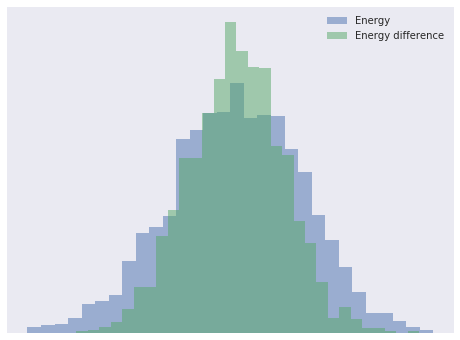

In [66]:
energy_plot(time_trace)

In [67]:
waic_df = waic_df.append(get_waic_df(time_model, time_trace, "Time"))

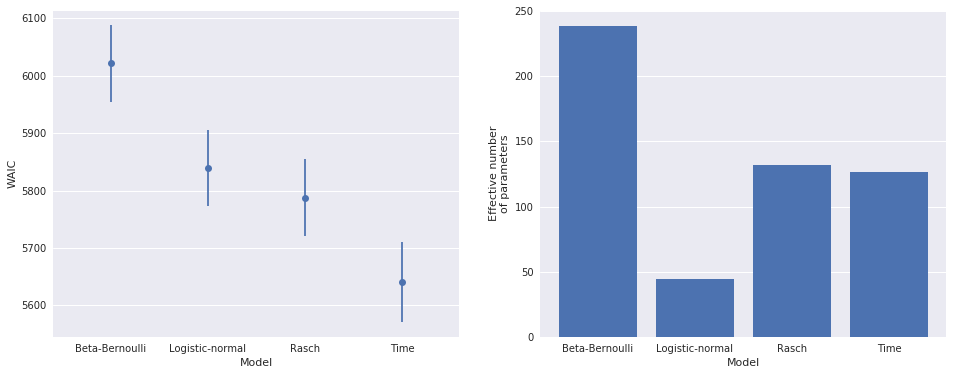

In [68]:
waic_plot(waic_df)

We see that the time remaining model represents an appreciable improvement over the Rasch model in terms of WAIC.

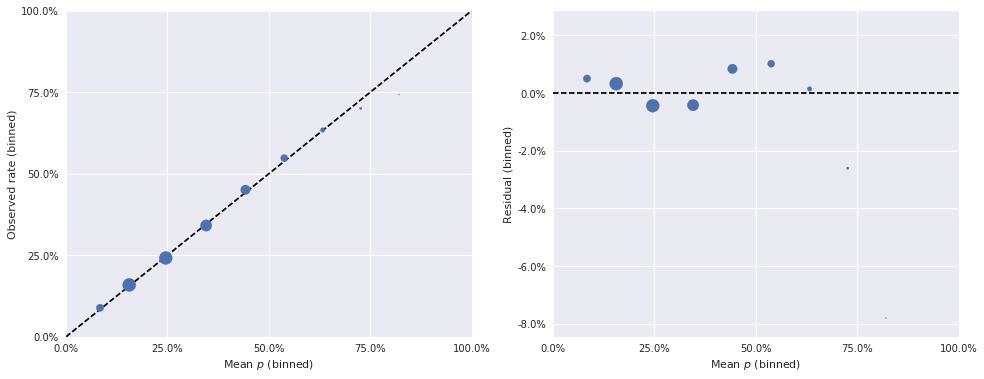

In [69]:
bin_obs, bin_p, bin_counts = binned_residuals(foul_called, time_trace['p'])

binned_residual_plot(bin_obs, bin_p, bin_counts)

The binned residuals for this model also look quite good, with very few samples appreciably exceeding a 1% difference.

We now compare the distribtuions of $\theta_i$ and $b_j$ for this model with those for the Rasch model.

In [70]:
time_df = to_param_df(team_player_map, time_trace, ['θ', 'b'])

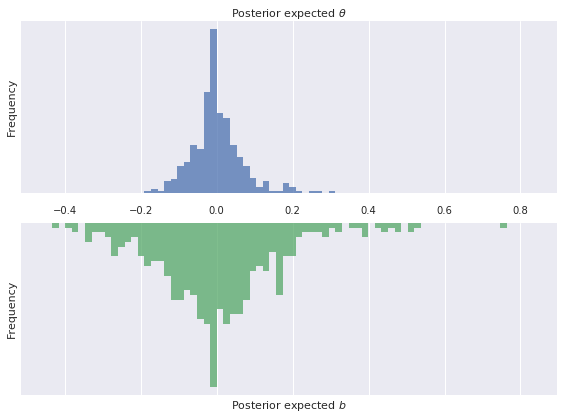

In [71]:
plot_latent_distributions(time_df.θ_mean, time_df.b_mean)

The effect of constraining the mean of $\theta$ to be zero is immediately apparent.  Also, the variation in $\theta$ remains lower than the variation than $b$ in this model.  We also see that the top- and bottom-ten players by $\theta$- and $b$-value remain largely unchanged from the Rasch model.

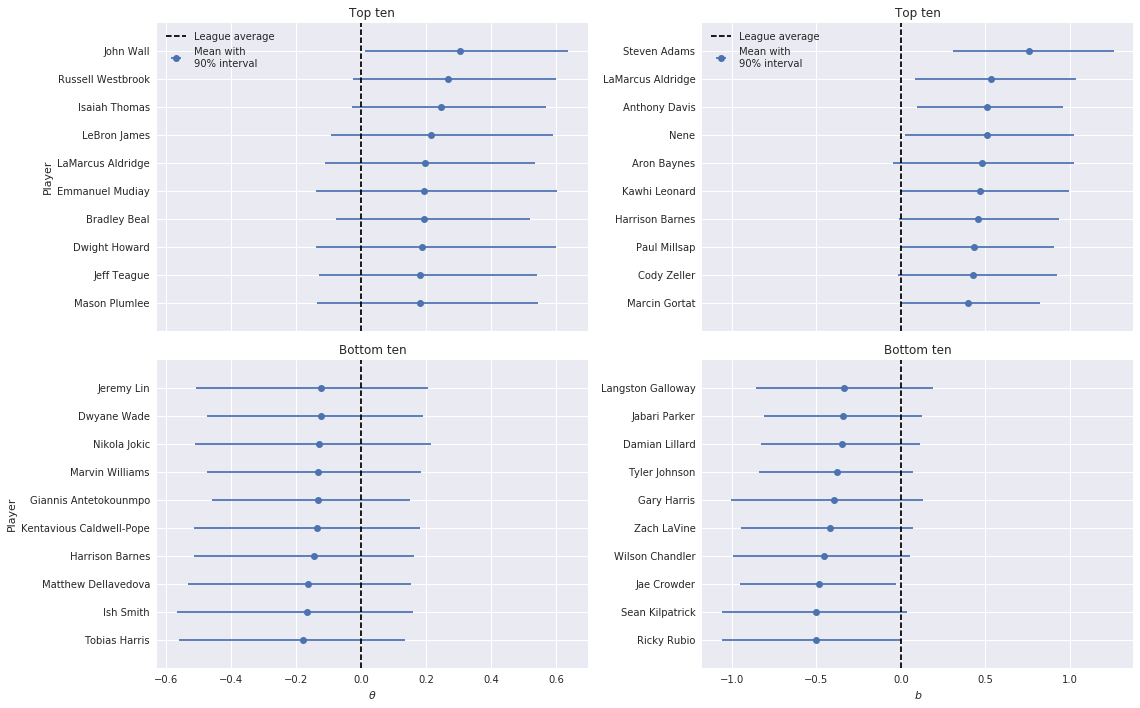

In [72]:
top_10_plot(time_df)

Basketball fans may find it amusing that under this model, Dwight Howard has joined the top-ten in terms of $\theta$ and Ricky Rubio is no longer the worst player in terms of $b$.

While this model has not done much to change the rank-ordering of the most- and least-skilled players, it does enable us to plot per-player foul probabilities over time, as below.

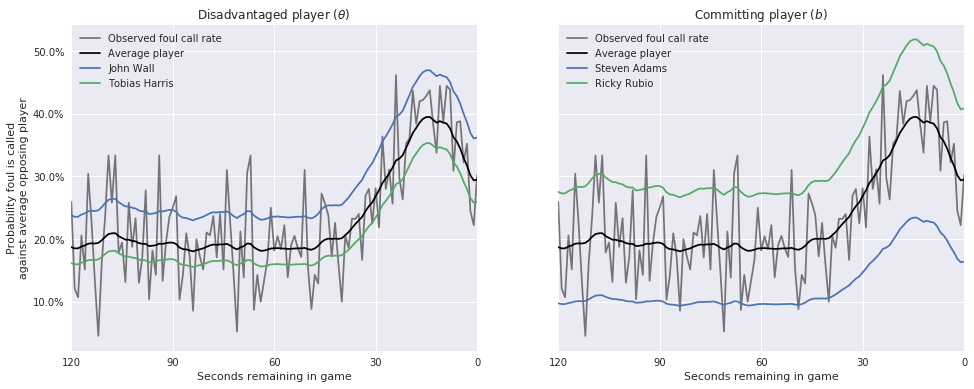

In [73]:
fig, (θ_ax, b_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(16, 6))

(df.groupby(sec)
   .foul_called
   .mean()
   .plot(c='k', alpha=0.5,
         label="Observed foul call rate",
         ax=θ_ax));

plot_sec = np.arange(n_sec)

θ_ax.plot(plot_sec, expit(time_trace['λ'].mean(axis=0)),
          c='k',
          label="Average player");

θ_best_id = time_df.ix[time_df.θ_mean.idxmax()].player_id
θ_ax.plot(plot_sec, expit(time_trace['θ'][:, θ_best_id].mean(axis=0) \
                          + time_trace['λ'].mean(axis=0)),
          label=player_map[θ_best_id]);

θ_worst_id = time_df.ix[time_df.θ_mean.idxmin()].player_id
θ_ax.plot(plot_sec, expit(time_trace['θ'][:, θ_worst_id].mean(axis=0) \
                          + time_trace['λ'].mean(axis=0)),
          label=player_map[θ_worst_id]);


θ_ax.set_xticks(np.linspace(0, 120, 5));
θ_ax.invert_xaxis();
θ_ax.set_xlabel("Seconds remaining in game");

θ_ax.yaxis.set_major_formatter(pct_formatter);
θ_ax.set_ylabel("Probability foul is called\nagainst average opposing player");

θ_ax.legend(loc=2);
θ_ax.set_title(r"Disadvantaged player ($\theta$)");

(df.groupby(sec)
   .foul_called
   .mean()
   .plot(c='k', alpha=0.5,
         label="Observed foul call rate",
         ax=b_ax));

plot_sec = np.arange(n_sec)

b_ax.plot(plot_sec, expit(time_trace['λ'].mean(axis=0)),
          c='k',
          label="Average player");

b_best_id = time_df.ix[time_df.b_mean.idxmax()].player_id
b_ax.plot(plot_sec, expit(-time_trace['b'][:, b_best_id].mean(axis=0) \
                          + time_trace['λ'].mean(axis=0)),
          label=player_map[b_best_id]);

b_worst_id = time_df.ix[time_df.b_mean.idxmin()].player_id
b_ax.plot(plot_sec, expit(-time_trace['b'][:, b_worst_id].mean(axis=0) \
                          + time_trace['λ'].mean(axis=0)),
          label=player_map[b_worst_id]);


b_ax.set_xticks(np.linspace(0, 120, 5));
b_ax.invert_xaxis();
b_ax.set_xlabel("Seconds remaining in game");

b_ax.legend(loc=2);
b_ax.set_title(r"Committing player ($b$)");

Here we have plotted the probability of a foul call while being opposed by an average player (for both $\theta$ and $b$), along with the probability curves for the players with the highest and lowest $\theta$ and $b$, respectively. While these plots are quite interesting, one weakness of our model is that the difference between each player's curve and the league average is constant over time.  It would be an interesting and useful to extend this model to allow player offsets to vary over time.  Additonally, it would be interesting to understand the influence of the score on the foul-called rate as the game nears its end.  It seems quite likely that the winning team is much less likely to commit fouls while the losing team is much more likely to to commit intentional fouls in close games.

We now plot the per-player values of $\theta_i$ and $b_j$ under this model.

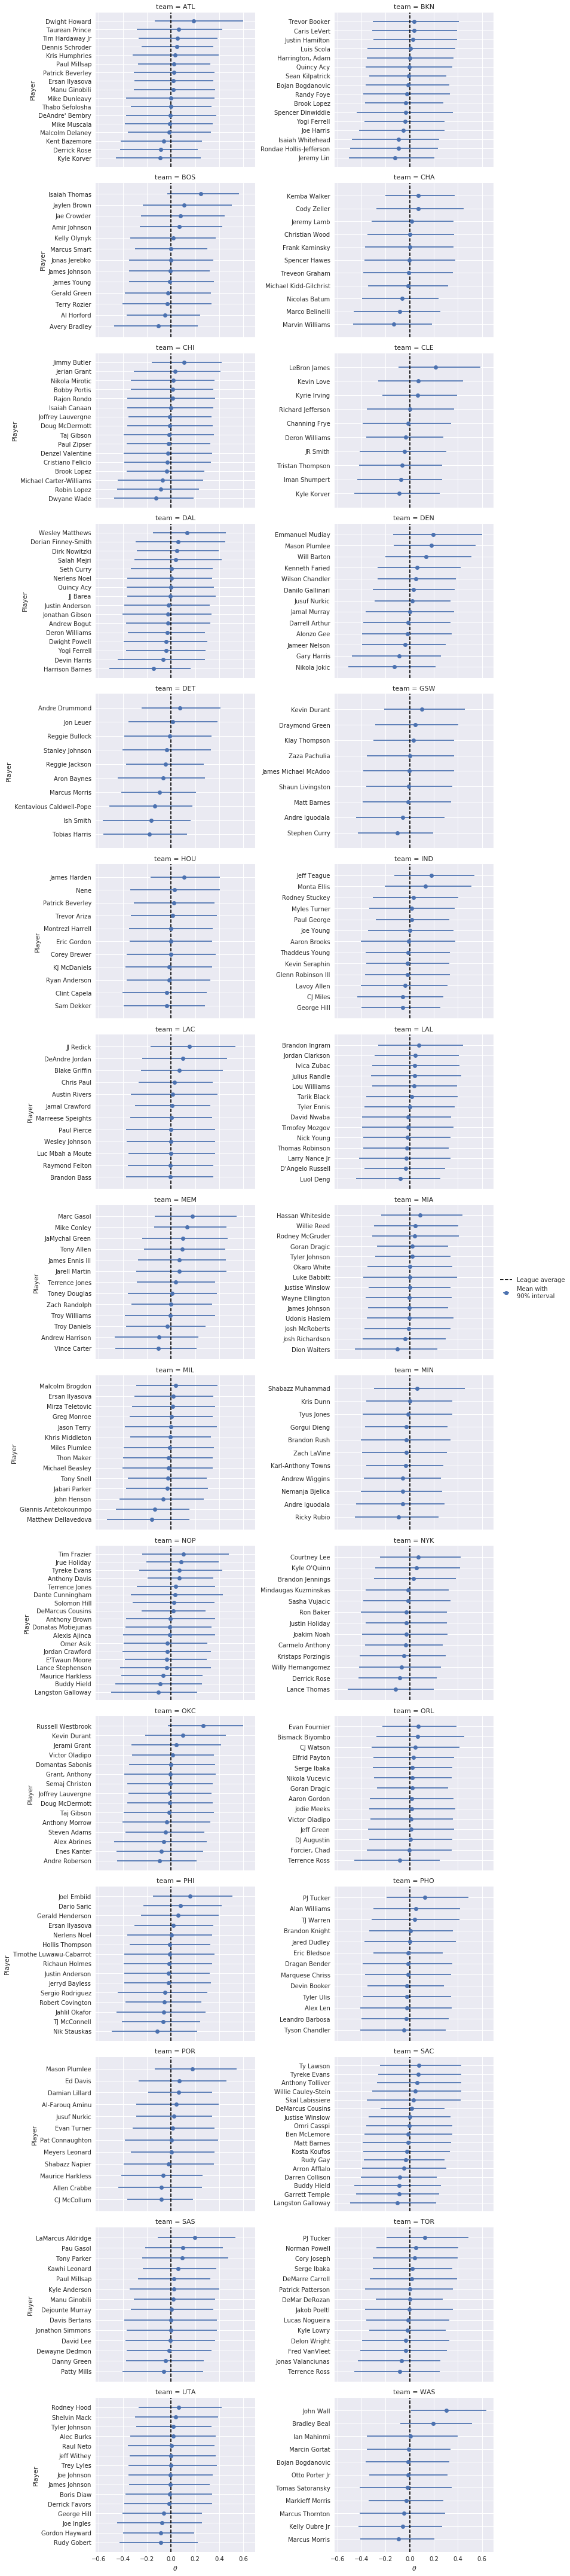

In [74]:
grid = sns.FacetGrid(time_df, col='team', col_wrap=2,
                     sharey=False,
                     size=4, aspect=1.5)
grid.map(plot_params_helper,
         'θ_mean', 'θ_low', 'θ_high', 'name',
         league_mean=0.,
         league_mean_name="League average");

grid.set_axis_labels(r"$\theta$", "Player");

grid.fig.tight_layout();
grid.add_legend();

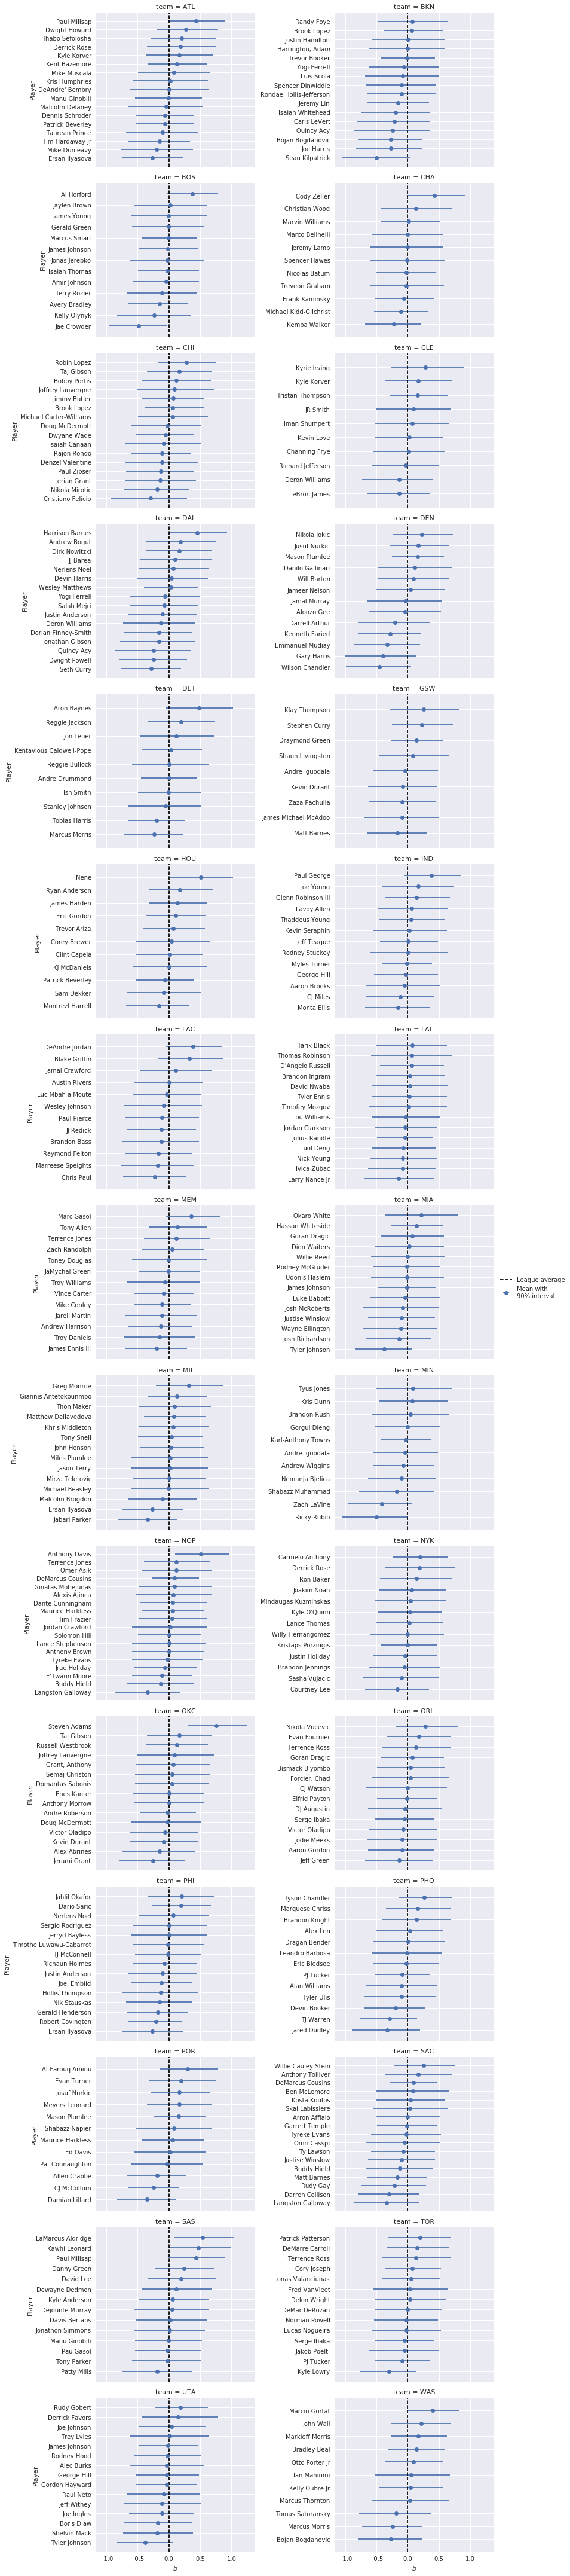

In [75]:
grid = sns.FacetGrid(time_df, col='team', col_wrap=2,
                     sharey=False,
                     size=4, aspect=1.5)
grid.map(plot_params_helper,
         'b_mean', 'b_low', 'b_high', 'name',
         league_mean=0.,
         league_mean_name="League average");

grid.set_axis_labels(r"$b$", "Player");

grid.fig.tight_layout();
grid.add_legend();

### Salary model

Our final model uses salary as a proxy for "star power" to explore its influence on foul calls.  We also (somewhat naively) impute missing salaries to the (log) league average.

In [76]:
std_log_salary = (salary_df.ix[np.arange(n_players)]
                           .std_log_salary
                           .fillna(0)
                           .values)

With $s_i$ denoting the $i$-the player's standardized log salary, our model becomes

$$
\begin{align*}
\theta_i
    & = \theta_{0, i} + \delta_{\theta} \cdot s_i \\
b_j
    & = b_{0, j} + \delta_b \cdot s_j \\
\eta_k
    & = \lambda_{t(k)} + \theta_{i(k)} - b_{j(k)}.
\end{align*}
$$

In this model, each player's $\theta_i$ and $b_j$ parameters are linear functions of their standardized log salary, with (hierarchical) varying intercepts.  The varying intercepts $\theta_{0, i}$ and $b_{0, j}$ are endowed with the same hierarchical normal priors as $\theta_i$ and $b_j$ had in the previous model.  We place normal priors, $\delta_{\theta} \sim N(0, 100)$ and $\delta_b \sim N(0, 100)$, on the salary coefficients.

In [77]:
with pm.Model() as salary_model:
    τ_λ = pm.Exponential('τ_λ', 1e-4)
    λ = pm.GaussianRandomWalk('λ', tau=τ_λ,
                              init=pm.Normal.dist(0., 10.),
                              shape=n_sec)
    
    Δ_θ0 = pm.Normal('Δ_θ0', 0., 1., shape=n_players)
    σ_θ0 = pm.HalfCauchy('σ_θ0', 2.5)
    θ0 = pm.Deterministic('θ0', Δ_θ0 * σ_θ0)
    
    δ_θ = pm.Normal('δ_θ', 0., 10.)
    
    θ = pm.Deterministic('θ', θ0 + δ_θ * std_log_salary)
    
    Δ_b0 = pm.Normal('Δ_b0', 0., 1., shape=n_players)
    σ_b0 = pm.HalfCauchy('σ_b0', 2.5)
    b0 = pm.Deterministic('b0', Δ_b0 * σ_b0)
    
    δ_b = pm.Normal('δ_b', 0., 10.)
    
    b = pm.Deterministic('b', b0 + δ_b * std_log_salary)
    
    η = λ[sec] + θ[disadvantaged_id] - b[committing_id]
    p = pm.Deterministic('p', pm.math.sigmoid(η))

    y = pm.Bernoulli('y_obs', p, observed=foul_called)

In [78]:
salary_trace = sample(salary_model, N_TUNE, N_SAMPLES, SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -1.0244e+05:  15%|█▌        | 30998/200000 [00:32<02:57, 952.52it/s]Median ELBO converged.
Finished [100%]: Average ELBO = -2,995.3

100%|██████████| 4000/4000 [03:45<00:00, 17.76it/s]


The energy plot for this model looks a bit worse than that for the time remaining model.

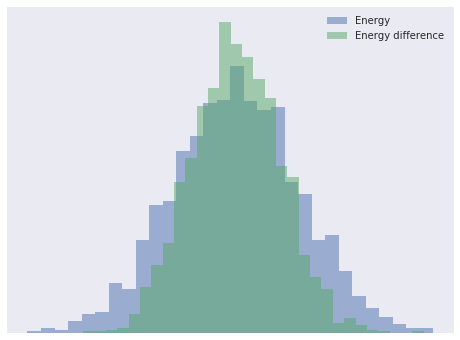

In [79]:
energy_plot(salary_trace)

The salary model also appears to be a slight improvement over the time remaining model in terms of WAIC.

In [80]:
waic_df = waic_df.append(get_waic_df(salary_model, salary_trace, "Salary"))

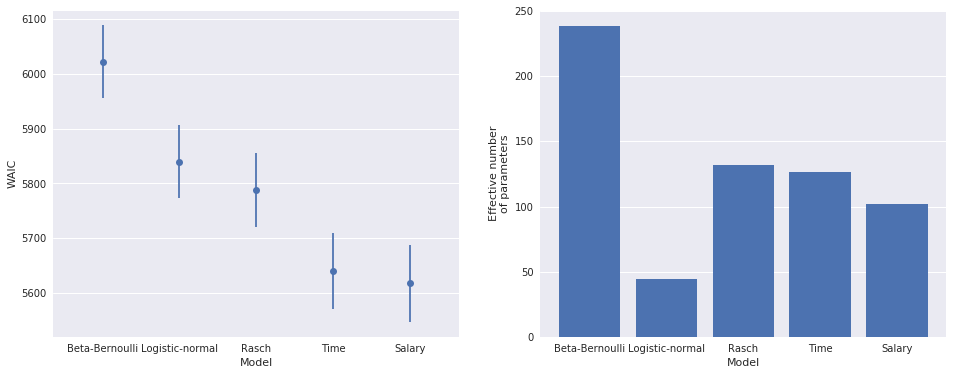

In [81]:
waic_plot(waic_df)

The binned residuals continue to look good for this model.

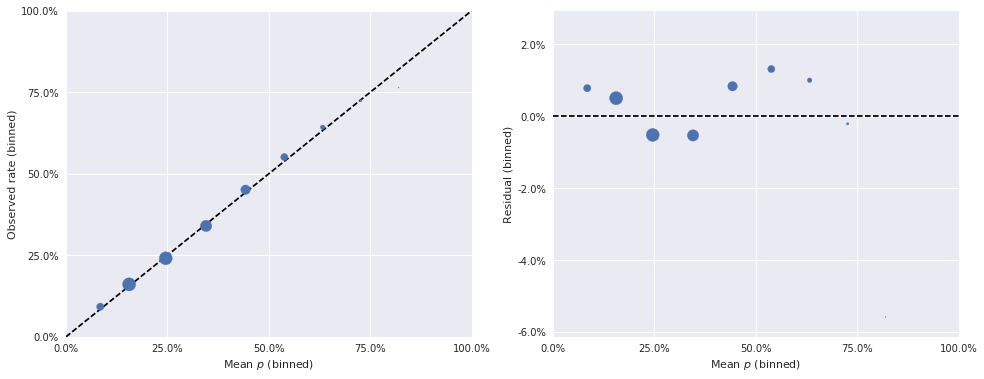

In [82]:
bin_obs, bin_p, bin_counts = binned_residuals(foul_called, salary_trace['p'])

binned_residual_plot(bin_obs, bin_p, bin_counts)

Based on the posterior distributions of $\delta_{\theta}$ and $\delta_b$, we expect to see a fairly strong relationship between a player's (standardized log) salary and their latent skill parameters.

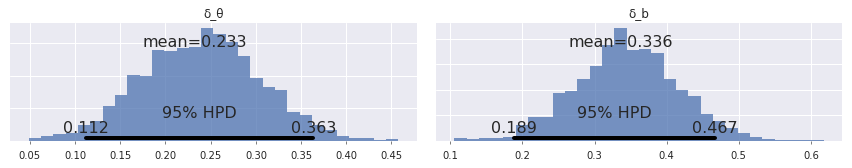

In [83]:
pm.plot_posterior(salary_trace, ['δ_θ', 'δ_b'],
                  lw=0., alpha=0.75);

The following plots confirm this relationship.

In [84]:
salary_df_ = to_param_df(team_player_map, salary_trace, ['θ', 'θ0', 'b', 'b0'])

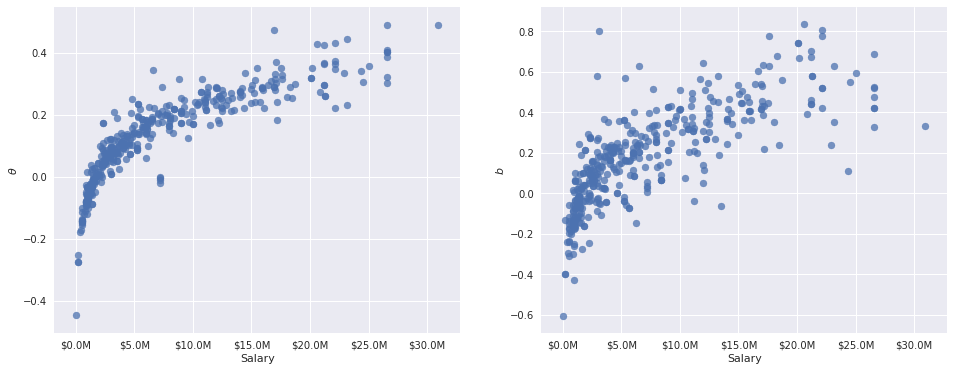

In [85]:
fig, (θ_ax, b_ax) = plt.subplots(ncols=2, sharex=True, figsize=(16, 6))

salary = (salary_df.ix[np.arange(n_players)]
                   .salary
                   .fillna(salary_df.salary.mean())
                   .values)

θ_ax.scatter(salary[salary_df_.player_id], salary_df_.θ_mean,
             alpha=0.75);

θ_ax.xaxis.set_major_formatter(million_dollars_formatter);
θ_ax.set_xlabel("Salary");

θ_ax.set_ylabel(r"$\theta$");

b_ax.scatter(salary[salary_df_.player_id], salary_df_.b_mean,
             alpha=0.75);

b_ax.xaxis.set_major_formatter(million_dollars_formatter);
b_ax.set_xlabel("Salary");

b_ax.set_ylabel(r"$b$");

It is important to note here that these relationships are descriptive, not causal.  Our original intent was to use salary as a proxy for the difficult-to-quantify notion of "star power."  These plots suggest that the probability of getting a foul called when disadvanted and not called when committing are both positively related to salary, and therefore (a bit more dubiously) star power. 

Importantly, $\theta_i$ and $b_j$ should no longer be interpreted directly as measuring latent skill, which is presumably intrinsic to a player and not directly dependent on their salary.  In fact, it seems at plausible that NBA scouts, front offices, players, and agents would be somewhat able to appreciate these latent skills, place a value on them, and thereby price them into contracts.  It would be interesting future work to refine this model to  give an [econometric](https://en.wikipedia.org/wiki/Econometrics) answer to this question.

Since we shouldn't interpret $\theta_i$ and $b_j$ as measures of latent skill in this model, we will not plot their per-player distributions.

## Conclusion

We set out to explore the relationship between players involved in a play and the probability that a foul is called, along with other factors related to that probability.  Through a series of progressively more complex Bayesian item-response models, we have seen that

1. foul call probability does vary appreciably across both disadvantaged and committing player,
2. there is more variation in the latent skill of the committing player to avoid a foul call than there is in the variation in the latent skill of the disadvantaged player to draw a foul call,
3. the amount of time remaining in the game is strongly related to the probability of a foul call, and
4. there is a positive relationship between player salary and the probability that a foul is called when they are disadvantaged and not called when they are committing.  With a bit of a leap, we can say that the probability a foul is called is at least loosely related to the "star power" of the players involved.

In this post we have only scratched the surface of Bayesian item-response theory.  For a more in-depth treatment, consult [_Bayesian Item Response Modeling_](http://www.springer.com/us/book/9781441907417).

This is is available as a Jupyter notebook [here](https://gist.github.com/AustinRochford/d1eb474ad4802e1b9edc790c4a9d2e0d).